In [2]:
import os

# IMPORTANT: Fix for PyTorch/IPython compatibility issue
# This must run BEFORE importing torch to avoid decorator conflicts
# This fixes the "disable() got an unexpected keyword argument 'wrapping'" error

# Method 1: Try to disable dynamo via environment variable (needs to be set before import)
os.environ.setdefault('TORCH_COMPILE_DISABLE', '1')

import torch

# Method 2: Patch torch._dynamo.disable decorator after import
try:
    import torch._dynamo
    # Patch the disable function to ignore the 'wrapping' parameter
    if hasattr(torch._dynamo, 'disable'):
        original_disable = torch._dynamo.disable
        def patched_disable(fn=None, *args, **kwargs):
            # Remove problematic 'wrapping' parameter if present
            if 'wrapping' in kwargs:
                kwargs.pop('wrapping')
            if fn is None:
                # Decorator usage: @disable
                return lambda f: f
            # Function usage: disable(fn) or disable(fn, **kwargs)
            try:
                return original_disable(fn, *args, **kwargs)
            except TypeError:
                # If original still fails, just return the function unwrapped
                return fn
        torch._dynamo.disable = patched_disable
except Exception as e:
    print(f"Warning: Could not patch torch._dynamo: {e}")
    pass  # If patching fails, continue anyway

import random, string

from torchtext import data , datasets
from collections import defaultdict, Counter
import numpy as np

os.environ['GENSIM_DATA_DIR'] = os.path.join(os.getcwd(), 'gensim-data')

import gensim.downloader as api
from gensim.models import KeyedVectors
from gensim.models.fasttext import load_facebook_model

from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import time

In [3]:
### Part 0: Dataset Preparation

# For tokenization
TEXT = data.Field ( tokenize = 'spacy', tokenizer_language = 'en_core_web_sm', include_lengths = True )

# For multi - class classification labels
LABEL = data.LabelField ()

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Load the TREC dataset
# Train / Validation / Test split
train_data, test_data = datasets.TREC.splits( TEXT, LABEL, fine_grained = False )

train_data, validation_data = train_data.split(
    split_ratio=0.8,
    stratified=True,
    strata_field='label',
    random_state=random.seed(42)
)
print(vars(train_data.examples[0]))


# Count how many samples per label in the train set
label_counts = Counter([ex.label for ex in train_data.examples])
total_examples = len(train_data)

print("\nLabel distribution in training set:")
for label, count in sorted(label_counts.items()):
    percentage = (count / total_examples) * 100
    print(f"- {label}: {count} samples ({percentage:.2f}%)")

# Optional sanity check: total percentages should sum ≈ 100%
total_percentage = sum((count / total_examples) * 100 for count in label_counts.values())
print(f"Total samples: {total_examples}, Sum of percentages: {total_percentage:.2f}%")


{'text': ['What', 'does', 'Elysium', 'mean', '?'], 'label': 'DESC'}

Label distribution in training set:
- ABBR: 69 samples (1.58%)
- DESC: 930 samples (21.32%)
- ENTY: 1000 samples (22.93%)
- HUM: 978 samples (22.42%)
- LOC: 668 samples (15.31%)
- NUM: 717 samples (16.44%)
Total samples: 4362, Sum of percentages: 100.00%


# Part 1: Prepare Word Embeddings

In [4]:
#### a) Size of Vocabulary formed from training data according to tokenization method
# Vocabulary size (includes specials like <unk>, <pad>)
TEXT.build_vocab(train_data, min_freq=1)
vocab_size = len(TEXT.vocab)
print("Vocabulary Size (with specials):", vocab_size)

vocab_wo_specials = len([w for w in TEXT.vocab.stoi if w not in {TEXT.unk_token, TEXT.pad_token}])
print("Vocabulary size (no specials):", vocab_wo_specials)

Vocabulary Size (with specials): 8143
Vocabulary size (no specials): 8141


In [5]:
#### b) How many OOV words exist in your training data?
####    What is the number of OOV words for each topic category?
# Load Word2Vec model from local file instead of downloading
# w2v = api.load('word2vec-google-news-300')
w2v = KeyedVectors.load('word2vec-google-news-300.model')
w2v_vocab = w2v.key_to_index

# Get training vocab tokens (types), excluding specials
specials = {TEXT.unk_token, TEXT.pad_token}
train_vocab_types = [w for w in TEXT.vocab.stoi.keys() if w not in specials]

# Overall OOV types in training vocab
oov_types_overall = {w for w in train_vocab_types if w not in w2v_vocab}
print("Number of OOV word types (overall):", len(oov_types_overall))

# OOV types per label (unique types per category across its sentences)
label_to_oov_types = defaultdict(set)
label_to_total_types = defaultdict(set)

for ex in train_data.examples:
    label = ex.label
    # Count by unique types per sentence to avoid overcounting repeats
    for w in set(ex.text):
        label_to_total_types[label].add(w)
        if w not in specials and w not in w2v_vocab:
            label_to_oov_types[label].add(w)

print("\nOOV word types per topic label:")
for label in sorted(label_to_total_types.keys()):
    num_oov = len(label_to_oov_types[label])
    num_types = len(label_to_total_types[label])
    rate = (num_oov / num_types) if num_types > 0 else 0.0
    print(f"- {label}: {num_oov} OOV types (out of {num_types}, rate={rate:.2%})")

Number of OOV word types (overall): 419

OOV word types per topic label:
- ABBR: 13 OOV types (out of 134, rate=9.70%)
- DESC: 118 OOV types (out of 2278, rate=5.18%)
- ENTY: 153 OOV types (out of 2991, rate=5.12%)
- HUM: 146 OOV types (out of 3053, rate=4.78%)
- LOC: 86 OOV types (out of 1795, rate=4.79%)
- NUM: 76 OOV types (out of 1911, rate=3.98%)


In [6]:
# #### c) OOV mitigation strategy (No transformer-based language models allowed)
# Implement your solution in your source code. Show the corresponding code snippet.
# 1. Fast Text Model Implementatation
# Load FastText with subword info (pretrained on Wikipedia)
# First download is large; cached afterwards

# 2. Modelling Unknown (<UNK>) token approach
# Make the <unk> vector informative and trainable by initializing it
# as the mean of available pretrained vectors.

# Loading fasttext model
fatter_fasttext_bin = load_facebook_model('crawl-300d-2M-subword/crawl-300d-2M-subword.bin')
embedding_dim = fatter_fasttext_bin.wv.vector_size

# Build embedding matrix aligned to TEXT.vocab
num_tokens = len(TEXT.vocab)
emb_matrix = np.zeros((num_tokens, embedding_dim), dtype=np.float32)

# torchtext 0.4.0: TEXT.vocab.itos is index->token, stoi is token->index
pad_tok = TEXT.pad_token
unk_tok = TEXT.unk_token

# Getting index of <unk> in vocab
unk_index = TEXT.vocab.stoi[TEXT.unk_token]
known_vecs = []

for idx, token in enumerate(TEXT.vocab.itos):
    # Skip specials here; we will set them explicitly below
    if token in {pad_tok, unk_tok}:
        continue

    vec = fatter_fasttext_bin.wv[token]
    emb_matrix[idx] = vec
    known_vecs.append(vec)

if len(known_vecs) > 0:
    unk_mean = torch.tensor(np.mean(known_vecs, axis=0), dtype=torch.float32)
else:
    unk_mean = torch.empty(embedding_dim).uniform_(-0.05, 0.05)
with torch.no_grad():
    emb_matrix[unk_index] = unk_mean

# Create Embedding layer initialized with FastText
fatter_embedding = torch.nn.Embedding(num_tokens, embedding_dim, padding_idx=TEXT.vocab.stoi[TEXT.pad_token])
fatter_embedding.weight.data.copy_(torch.from_numpy(emb_matrix))

torch.save(fatter_embedding, 'embedding_weights_fatter_fasttext.pt')

In [7]:
#### d) Select the 20 most frequent words from each topic category in the training set (removing
# stopwords if necessary). Retrieve their pretrained embeddings (from Word2Vec or GloVe).
# Project these embeddings into 2D space (using e.g., t-SNE or Principal Component Analysis).
# Plot the points in a scatter plot, color-coded by their topic category. Attach your plot here.
# Analyze your findings.

# Build per-label token frequency (lowercased, stopwords/punct filtered)
label_to_counter = defaultdict(Counter)
valid_chars = set(string.ascii_letters)

def is_valid_token(tok: str) -> bool:
    t = tok.strip("'\"")
    if len(t) == 0:
        return False
    # Keep purely alphabetic tokens to avoid punctuation/numbers
    return t.isalpha()

for ex in train_data.examples:
    label = ex.label
    for tok in ex.text:
        tok_l = tok.lower()
        if tok_l in STOP_WORDS:
            continue
        if not is_valid_token(tok_l):
            continue
        label_to_counter[label][tok_l] += 1

# Select top 20 per label that exist in Word2Vec
topk = 20
label_to_top_tokens = {}
for label, ctr in label_to_counter.items():
    selected = []
    for tok, _ in ctr.most_common():
        if tok in w2v.key_to_index:
            selected.append(tok)
        if len(selected) >= topk:
            break
    label_to_top_tokens[label] = selected

# Collect embeddings and labels
points = []
point_labels = []
point_words = []
for label, toks in label_to_top_tokens.items():
    for tok in toks:
        vec = w2v.get_vector(tok)
        points.append(vec)
        point_labels.append(label)
        point_words.append(tok)

if len(points) > 0:
    X = np.vstack(points)

    # 2D projections
    tsne_2d = TSNE(n_components=2, random_state=42, init="pca", perplexity=30).fit_transform(X)
    pca_2d = PCA(n_components=2, random_state=42).fit_transform(X)

    # Assign colors per label
    unique_labels = sorted(set(point_labels))
    color_map = {lab: plt.cm.tab10(i % 10) for i, lab in enumerate(unique_labels)}

    def plot_scatter(Y2, title: str, fname: str):
        plt.figure(figsize=(10, 8))
        for lab in unique_labels:
            idxs = [i for i, l in enumerate(point_labels) if l == lab]
            plt.scatter(Y2[idxs, 0], Y2[idxs, 1], c=[color_map[lab]], label=lab, alpha=0.8, s=40)
            # Light word annotations (optional; can clutter)
            for i in idxs:
                plt.annotate(point_words[i], (Y2[i, 0], Y2[i, 1]), fontsize=7, alpha=0.7)
        plt.legend(title="TREC label")
        plt.title(title)
        plt.tight_layout()
        plt.savefig(fname, dpi=200)
        plt.close()

    plot_scatter(tsne_2d, "Top-20 per TREC label (Word2Vec) - t-SNE", "trec_top20_tsne.png")
    plot_scatter(pca_2d, "Top-20 per TREC label (Word2Vec) - PCA", "trec_top20_pca.png")

    print("Saved plots: trec_top20_tsne.png, trec_top20_pca.png")
    for lab in unique_labels:
        print(f"{lab}: {label_to_top_tokens[lab]}")
else:
    print("No points collected for visualization. Check filtering or embedding availability.")

Saved plots: trec_top20_tsne.png, trec_top20_pca.png
ABBR: ['stand', 'abbreviation', 'mean', 'acronym', 'national', 'bureau', 'investigation', 'e', 'letters', 'computer', 'cnn', 'equation', 'zip', 'cpr', 'abbreviated', 'form', 'nasdaq', 'c', 'sids', 'btu']
DESC: ['mean', 'origin', 'difference', 'word', 'find', 'come', 'work', 'people', 'term', 'meaning', 'causes', 'like', 't', 'school', 'definition', 'called', 'time', 'happened', 'famous', 'computer']
ENTY: ['fear', 'kind', 'called', 'world', 'color', 'book', 'film', 'best', 'war', 'play', 'term', 'movie', 'tv', 'sport', 'animal', 'novel', 'drink', 'word', 'game', 'known']
HUM: ['president', 'wrote', 'company', 'world', 'famous', 'invented', 'tv', 'team', 'baseball', 'new', 'character', 'said', 'actor', 'known', 'won', 'star', 'american', 'portrayed', 'movie', 'woman']
LOC: ['country', 'city', 'world', 'state', 'find', 'largest', 'located', 'capital', 'river', 'countries', 'highest', 'information', 'live', 'american', 'island', 'states

In [8]:
fasttext = torch.load('embedding_weights_fatter_fasttext.pt', weights_only=False)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
### Part 2: Model Training & Evaluation - RNN

# Build vocabulary for labels
LABEL.build_vocab(train_data)
num_classes = len(LABEL.vocab)
print(f"\nNumber of classes: {num_classes}")
print(f"Classes: {LABEL.vocab.itos}")

# Create iterators for batching (inline for easier debugging)
# train_iterator = data.BucketIterator(...)
# val_iterator = data.BucketIterator(...)
# test_iterator = data.BucketIterator(...)
# (Used directly in Part 2 execution below)


class SimpleRNNClassifier(nn.Module):
    """
    Simple RNN for topic classification (Baseline - no dropout).
    Uses pretrained embeddings (learnable/updated during training) with OOV mitigation 
    and aggregates word representations to sentence representation using the last hidden state.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
                 n_layers=1, dropout=0.0, padding_idx=0, pretrained_embeddings=None):
        super(SimpleRNNClassifier, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # Embedding layer initialized with pretrained embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
            # IMPORTANT: Make embeddings learnable (updated during training)
            # This allows fine-tuning of embeddings including OOV words handled by FastText
            self.embedding.weight.requires_grad = True
        
        # Simple RNN layer (no dropout in baseline)
        self.rnn = nn.RNN(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=0.0  # No dropout in baseline
        )
        
        # Removed: Dropout layer (baseline has no regularization)
        # self.dropout = nn.Dropout(dropout)
        
        # Fully connected output layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        # text: [batch_size, seq_len]
        # text_lengths: [batch_size]
        
        # Embed the input
        embedded = self.embedding(text)  # [batch_size, seq_len, embedding_dim]
        
        # Get dimensions
        batch_size = embedded.size(0)
        seq_len = embedded.size(1)
        
        # Handle text_lengths: ensure it's a 1D tensor with batch_size elements
        text_lengths_flat = text_lengths.flatten().cpu().long()
        
        # text_lengths should have exactly batch_size elements (one length per batch item)
        if len(text_lengths_flat) != batch_size:
            raise ValueError(
                f"text_lengths size mismatch: got {len(text_lengths_flat)} elements, "
                f"expected {batch_size} (batch_size). text_lengths.shape={text_lengths.shape}, "
                f"text.shape={text.shape}, embedded.shape={embedded.shape}"
            )
        
        # Clamp lengths to be at most the sequence length (safety check)
        text_lengths_clamped = torch.clamp(text_lengths_flat, min=1, max=seq_len)
        
        # Pack the padded sequences for efficient processing
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths_clamped, batch_first=True, enforce_sorted=False
        )
        
        # Pass through RNN
        packed_output, hidden = self.rnn(packed_embedded)
        # hidden: [n_layers, batch_size, hidden_dim]
        
        # Use the last hidden state from the last layer
        last_hidden = hidden[-1]  # [batch_size, hidden_dim]
        
        # Removed: Apply dropout (baseline has no regularization)
        # last_hidden = self.dropout(last_hidden)
        
        # Pass through fully connected layer
        output = self.fc(last_hidden)  # [batch_size, output_dim]
        
        return output


# Utility function for counting parameters
def count_parameters(model):
    """Count trainable parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Training and evaluation functions removed - code is now inline below for easier debugging


Number of classes: 6
Classes: ['ENTY', 'HUM', 'DESC', 'NUM', 'LOC', 'ABBR']


In [11]:
print(len(TEXT.vocab))

8143


Training order:
1. Word aggregation
2. Hyperparameters tuning
3. Regularization

In [12]:
# ============================================================================
# Part 2: Initial Simple RNN Model Training
# ============================================================================

print("\n" + "="*80)
print("PART 2: SIMPLE RNN MODEL TRAINING")
print("="*80)

# Get pretrained embeddings from Part 1 (frozen embeddings)
pretrained_embeddings = fasttext.weight.data

# Get embedding dimension and vocab size from the fasttext embedding layer
embedding_dim = fasttext.weight.shape[1]
fasttext_vocab_size = fasttext.weight.shape[0]  # Vocab size from saved embedding

# Verify vocab sizes match (they might differ if vocab was rebuilt)
print(f"TEXT.vocab size: {len(TEXT.vocab)}")
print(f"FastText embedding vocab size: {fasttext_vocab_size}")

# Hyperparameters
BATCH_SIZE = 64
HIDDEN_DIM = 256
N_LAYERS = 1
DROPOUT = 0.0  # Baseline: no dropout
N_EPOCHS = 100
LEARNING_RATE = 0.001
# Removed: PATIENCE = 10  # Baseline: no early stopping

# Create data iterators (inline for easier debugging)
# Note: Different sequence lengths per batch are normal - BucketIterator groups similar-length sequences
train_iterator = data.BucketIterator(
    train_data,
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=True,  # Shuffle for training
    device=device
)

val_iterator = data.BucketIterator(
    validation_data,
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,  # No shuffle for validation (deterministic)
    device=device
)

test_iterator = data.BucketIterator(
    test_data,
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,  # No shuffle for test (deterministic)
    device=device
)

# Initialize simple RNN model (Baseline)
# Use vocab size from loaded embedding to match the saved weights exactly
model = SimpleRNNClassifier(
    vocab_size=fasttext_vocab_size,  # Must match saved embedding vocab size
    embedding_dim=embedding_dim,
    hidden_dim=HIDDEN_DIM,
    output_dim=num_classes,
    n_layers=N_LAYERS,
    dropout=0.0,  # Baseline: no dropout
    padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
    pretrained_embeddings=pretrained_embeddings
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"\n>>> Training Baseline RNN Model")
print(f"Configuration:")
print(f"  - Hidden Dim: {HIDDEN_DIM}")
print(f"  - Layers: {N_LAYERS}")
print(f"  - Dropout: {DROPOUT} (Baseline: no regularization)")
print(f"  - Learning Rate: {LEARNING_RATE}")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Epochs: {N_EPOCHS} (no early stopping)")
print(f"  - Embedding Dim: {embedding_dim} (FastText)")
print(f"  - Embeddings: LEARNABLE (updated during training)")
print(f"  - OOV Handling: FastText subword embeddings + trainable <unk> token")

# ============================================================================
# Helper function to process batches consistently
# ============================================================================

def process_batch(batch, debug=False):
    """
    Process a batch from BucketIterator, handling text transpose correctly.
    Returns: text, text_lengths, labels (all properly formatted)
    """
    text, text_lengths = batch.text
    labels = batch.label
    
    if debug:
        print(f"DEBUG BATCH - text shape: {text.shape}, text_lengths shape: {text_lengths.shape}, labels shape: {labels.shape}")
    
    # torchtext BucketIterator returns text as [seq_len, batch_size] by default
    # We need [batch_size, seq_len] for batch_first=True in the model
    expected_batch_size = labels.shape[0]
    
    if text.dim() == 2:
        if text.shape[1] == expected_batch_size and len(text_lengths) == expected_batch_size:
            # text is [seq_len, batch_size], transpose to [batch_size, seq_len]
            text = text.transpose(0, 1)
            if debug:
                print(f"DEBUG BATCH - Transposed text to [batch_size, seq_len]: {text.shape}")
        elif text.shape[0] == expected_batch_size and len(text_lengths) == expected_batch_size:
            # text is already [batch_size, seq_len]
            if debug:
                print(f"DEBUG BATCH - text already in correct format: {text.shape}")
        else:
            raise ValueError(
                f"Cannot determine text format: text.shape={text.shape}, "
                f"text_lengths.shape={text_lengths.shape}, labels.shape={labels.shape}"
            )
    
    # Verify dimensions match
    assert text.shape[0] == len(text_lengths) == labels.shape[0], \
        f"Batch size mismatch: text.shape[0]={text.shape[0]}, len(text_lengths)={len(text_lengths)}, labels.shape[0]={labels.shape[0]}"
    
    return text, text_lengths, labels

# Set seeds for reproducibility
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Note: PyTorch/IPython compatibility fix is already applied in cell 0
# The torch._dynamo.disable decorator has been patched to handle the 'wrapping' parameter

# ============================================================================
# Training Loop (inline for easier debugging)
# ============================================================================

best_val_acc = 0
# Removed: patience_counter = 0  # Baseline: no early stopping

train_losses = []
train_accs = []
val_losses = []
val_accs = []

print(f"\nStarting training for {N_EPOCHS} epochs...")  # Removed "up to" - no early stopping
print(f"Device: {device}")
print(f"Trainable parameters: {count_parameters(model):,}")
print(f"Embedding layer learnable: {model.embedding.weight.requires_grad}")
# Removed: print(f"Early stopping patience: {PATIENCE} epochs")  # Baseline: no early stopping
print("-" * 80)

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    # ========================================================================
    # Training for one epoch (inline)
    # ========================================================================
    model.train()
    train_epoch_loss = 0
    train_all_preds = []
    train_all_labels = []
    
    batch_idx = 0
    for batch in train_iterator:
        # Process batch (with debug only for first batch)
        text, text_lengths, labels = process_batch(batch, debug=(batch_idx == 0))
        batch_idx += 1
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        predictions = model(text, text_lengths)
        
        # Calculate loss
        loss = criterion(predictions, labels)
        
        # Backward pass
        loss.backward()
        
        # Removed: Gradient clipping (baseline has no gradient clipping)
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Update weights
        optimizer.step()
        
        train_epoch_loss += loss.item()
        
        # Store predictions and labels for metrics
        preds = torch.argmax(predictions, dim=1)
        train_all_preds.extend(preds.cpu().numpy())
        train_all_labels.extend(labels.cpu().numpy())
    
    # Calculate training accuracy
    train_acc = accuracy_score(train_all_labels, train_all_preds)
    train_loss = train_epoch_loss / len(train_iterator)
    
    # ========================================================================
    # Validation evaluation (inline)
    # ========================================================================
    model.eval()
    val_epoch_loss = 0
    val_all_preds = []
    val_all_labels = []
    
    with torch.no_grad():
        for batch in val_iterator:
            # Process batch consistently with training
            text, text_lengths, labels = process_batch(batch, debug=False)
            
            # Forward pass
            predictions = model(text, text_lengths)
            
            # Calculate loss
            loss = criterion(predictions, labels)
            val_epoch_loss += loss.item()
            
            # Store predictions and labels
            preds = torch.argmax(predictions, dim=1)
            val_all_preds.extend(preds.cpu().numpy())
            val_all_labels.extend(labels.cpu().numpy())
    
    # Calculate validation accuracy
    val_acc = accuracy_score(val_all_labels, val_all_preds)
    val_loss = val_epoch_loss / len(val_iterator)
    
    # ========================================================================
    # Logging (without early stopping)
    # ========================================================================
    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)
    
    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f'Epoch: {epoch+1:02}/{N_EPOCHS} | Time: {int(epoch_mins)}m {int(epoch_secs)}s')
    print(f'\tTrain Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%')
    
    # Track best model (but don't stop early - baseline trains for all epochs)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        # Save best model
        torch.save(model.state_dict(), 'rnn_simple_best.pt')
        print(f'\t>>> New best model saved with Val Acc: {val_acc*100:.2f}%')
    # Removed: Early stopping break logic (baseline trains for all epochs)

print("-" * 80)
print(f"Training completed! Best validation accuracy: {best_val_acc*100:.2f}%")
print(f"Total epochs trained: {N_EPOCHS}")


PART 2: SIMPLE RNN MODEL TRAINING
TEXT.vocab size: 8143
FastText embedding vocab size: 8143

>>> Training Baseline RNN Model
Configuration:
  - Hidden Dim: 256
  - Layers: 1
  - Dropout: 0.0 (Baseline: no regularization)
  - Learning Rate: 0.001
  - Batch Size: 64
  - Epochs: 100 (no early stopping)
  - Embedding Dim: 300 (FastText)
  - Embeddings: LEARNABLE (updated during training)
  - OOV Handling: FastText subword embeddings + trainable <unk> token

Starting training for 100 epochs...
Device: cuda
Trainable parameters: 2,587,290
Embedding layer learnable: True
--------------------------------------------------------------------------------
DEBUG BATCH - text shape: torch.Size([8, 64]), text_lengths shape: torch.Size([64]), labels shape: torch.Size([64])
DEBUG BATCH - Transposed text to [batch_size, seq_len]: torch.Size([64, 8])
Epoch: 01/100 | Time: 0m 8s
	Train Loss: 1.5678 | Train Acc: 32.49%
	Val Loss: 1.3797 | Val Acc: 43.39%
	>>> New best model saved with Val Acc: 43.39%
DEBU

In [13]:
# ============================================================================
# Validation Set Evaluation (inline) - Evaluate best model on validation set
# ============================================================================

print("\n" + "="*80)
print("VALIDATION SET EVALUATION (Best Model)")
print("="*80)

# Load best model and evaluate on validation set
model.load_state_dict(torch.load('rnn_simple_best.pt'))

model.eval()
val_eval_loss = 0
val_eval_preds = []
val_eval_labels = []
val_eval_probs = []  # Store probabilities for AUC-ROC

with torch.no_grad():
    for batch in val_iterator:
        text, text_lengths = batch.text
        labels = batch.label
        
        # Process batch consistently
        text, text_lengths, labels = process_batch(batch, debug=False)
        
        # Forward pass
        predictions = model(text, text_lengths)
        
        # Calculate loss
        loss = criterion(predictions, labels)
        val_eval_loss += loss.item()
        
        # Store predictions, labels, and probabilities
        probs = torch.softmax(predictions, dim=1)
        preds = torch.argmax(predictions, dim=1)
        val_eval_preds.extend(preds.cpu().numpy())
        val_eval_labels.extend(labels.cpu().numpy())
        val_eval_probs.extend(probs.cpu().numpy())

# Calculate validation metrics
val_eval_acc = accuracy_score(val_eval_labels, val_eval_preds)
val_eval_f1 = f1_score(val_eval_labels, val_eval_preds, average='weighted')
val_eval_loss_final = val_eval_loss / len(val_iterator)

# Calculate AUC-ROC (one-vs-rest for multiclass)
try:
    val_eval_probs_array = np.array(val_eval_probs)
    val_eval_labels_bin = label_binarize(val_eval_labels, classes=range(num_classes))
    val_eval_auc = roc_auc_score(val_eval_labels_bin, val_eval_probs_array, average='weighted', multi_class='ovr')
except Exception as e:
    print(f"Warning: Could not calculate AUC-ROC: {e}")
    val_eval_auc = 0.0

print(f"\n>>> Validation Set Results (Best Model):")
print(f"Validation Loss: {val_eval_loss_final:.4f}")
print(f"Validation Accuracy: {val_eval_acc*100:.2f}%")
print(f"Validation F1 Score: {val_eval_f1:.4f}")
print(f"Validation AUC-ROC: {val_eval_auc:.4f}")

# ============================================================================
# Test Set Evaluation (inline)
# ============================================================================

print("\n" + "="*80)
print("TEST SET EVALUATION")
print("="*80)

model.eval()
test_epoch_loss = 0
test_all_preds = []
test_all_labels = []
test_all_probs = []  # Store probabilities for AUC-ROC

with torch.no_grad():
    for batch in test_iterator:
        text, text_lengths = batch.text
        labels = batch.label
        
        # Process batch consistently
        text, text_lengths, labels = process_batch(batch, debug=False)
        
        # Forward pass
        predictions = model(text, text_lengths)
        
        # Calculate loss
        loss = criterion(predictions, labels)
        test_epoch_loss += loss.item()
        
        # Store predictions, labels, and probabilities
        probs = torch.softmax(predictions, dim=1)
        preds = torch.argmax(predictions, dim=1)
        test_all_preds.extend(preds.cpu().numpy())
        test_all_labels.extend(labels.cpu().numpy())
        test_all_probs.extend(probs.cpu().numpy())

# Calculate test metrics
test_acc = accuracy_score(test_all_labels, test_all_preds)
test_f1 = f1_score(test_all_labels, test_all_preds, average='weighted')
test_loss = test_epoch_loss / len(test_iterator)

# Calculate AUC-ROC (one-vs-rest for multiclass)
try:
    test_all_probs_array = np.array(test_all_probs)
    test_all_labels_bin = label_binarize(test_all_labels, classes=range(num_classes))
    test_auc = roc_auc_score(test_all_labels_bin, test_all_probs_array, average='weighted', multi_class='ovr')
except Exception as e:
    print(f"Warning: Could not calculate AUC-ROC: {e}")
    test_auc = 0.0

print(f"\n>>> Test Set Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test AUC-ROC: {test_auc:.4f}")

print("\n" + "="*80)
print("PART 2 INITIAL TRAINING COMPLETE")
print("="*80)


VALIDATION SET EVALUATION (Best Model)

>>> Validation Set Results (Best Model):
Validation Loss: 1.4150
Validation Accuracy: 68.44%
Validation F1 Score: 0.6817
Validation AUC-ROC: 0.8923

TEST SET EVALUATION

>>> Test Set Results:
Test Loss: 0.9124
Test Accuracy: 75.40%
Test F1 Score: 0.7497
Test AUC-ROC: 0.9185

PART 2 INITIAL TRAINING COMPLETE


In [22]:
# ============================================================================
# Part 2.2: Sequential Hyperparameter Tuning (One Variable at a Time)
# ============================================================================

print("\n" + "="*80)
print("PART 2.2: SEQUENTIAL HYPERPARAMETER TUNING")
print("="*80)

# ============================================================================
# ============================================================================
# Step 0: Epoch + Early Stopping Configuration Tuning
# ============================================================================
print("\n" + "="*80)
print("STEP 0: EPOCH + EARLY STOPPING TUNING")
print("="*80)
print("Testing different MAX_EPOCHS and PATIENCE configurations")

# Test different epoch and patience configurations
max_epochs_options = [100, 250, 500]
patience = 10

# Use baseline config for testing epoch settings
baseline_config = {
    'lr': 0.001,
    'batch_size': 64,
    'hidden_dim': 256,
    'optimizer': 'Adam'
}

step0_configs = []
for max_epochs in max_epochs_options:
        step0_configs.append({
            'config': baseline_config.copy(),
            'max_epochs': max_epochs,
            'patience': patience
        })

print(f"Total combinations to test: {len(step0_configs)}")
print("Combinations (Max_Epochs, Patience):")
for idx, ep_config in enumerate(step0_configs, 1):
    print(f"  {idx}. Max_Epochs={ep_config['max_epochs']}, Patience={ep_config['patience']}")

# Helper function to train with specific epoch/patience settings
def train_and_evaluate_with_epochs(config, max_epochs, patience, config_name="config"):
    """Train a model for specific number of epochs WITHOUT early stopping"""
    print(f"\n>>> Testing: {config_name}")
    print(f"    LR={config['lr']}, Batch={config['batch_size']}, Hidden={config['hidden_dim']}, Opt={config['optimizer']}")
    print(f"    Epochs={max_epochs} (NO early stopping - training for full {max_epochs} epochs)")
    
    # Create iterators with specific batch size
    train_iter = data.BucketIterator(
        train_data,
        batch_size=config['batch_size'],
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        shuffle=True,
        device=device
    )
    
    val_iter = data.BucketIterator(
        validation_data,
        batch_size=config['batch_size'],









        
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        shuffle=False,
        device=device
    )
    
    # Reset random seeds INSIDE function to ensure fresh model for each config
    # This is critical to ensure each max_epochs config starts from scratch
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)
    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # Create model with specific hidden dimension
    model = SimpleRNNClassifier(
        vocab_size=fasttext_vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=config['hidden_dim'],
        output_dim=num_classes,
        n_layers=N_LAYERS,
        dropout=0.0,  # Baseline: no dropout
        padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
        pretrained_embeddings=pretrained_embeddings
    ).to(device)
    
    # Select optimizer
    if config['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=config['lr'], momentum=0.9)
    elif config['optimizer'] == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=config['lr'])
    
    # Training loop WITHOUT early stopping - train for full num_epochs
    best_val_acc = 0.0
    best_val_acc_at_epoch = 0
    final_val_acc = 0.0
    
    for epoch in range(max_epochs):
        # Training
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        for batch in train_iter:
            text, text_lengths, labels = process_batch(batch, debug=False)
            optimizer.zero_grad()
            predictions = model(text, text_lengths)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            preds = torch.argmax(predictions, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_acc = accuracy_score(train_labels, train_preds)
        
        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_iter:
                text, text_lengths, labels = process_batch(batch, debug=False)
                predictions = model(text, text_lengths)
                loss = criterion(predictions, labels)
                val_loss += loss.item()
                
                preds = torch.argmax(predictions, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_acc = accuracy_score(val_labels, val_preds)
        
        # Track best validation accuracy (but don't stop early)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_acc_at_epoch = epoch + 1
        
        final_val_acc = val_acc  # Store final epoch's validation accuracy
        
        # Optional: print progress every 10 epochs or at the end
        if (epoch + 1) % 10 == 0 or (epoch + 1) == max_epochs:
            print(f"    Epoch {epoch+1}/{max_epochs}: Train Acc={train_acc*100:.2f}%, Val Acc={val_acc*100:.2f}%")
    
    print(f"    Final Val Acc: {final_val_acc*100:.2f}% | Best Val Acc: {best_val_acc*100:.2f}% (at epoch {best_val_acc_at_epoch}/{max_epochs})")
    return best_val_acc, best_val_acc_at_epoch, max_epochs

step0_results = []
for idx, ep_config in enumerate(step0_configs):
    # Set fixed seed for reproducibility - ensures consistent batch ordering
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
    
    val_acc, best_epoch, total_epochs = train_and_evaluate_with_epochs(
        ep_config['config'],
        ep_config['max_epochs'],
        ep_config['patience'],
        f"Step 0 Config {idx+1}/{len(step0_configs)}"
    )
    step0_results.append({
        'num_epochs': ep_config['max_epochs'],
        'val_acc': val_acc,
        'best_epoch': best_epoch,
        'total_epochs': total_epochs
    })

# Find best epoch configuration
best_step0 = max(step0_results, key=lambda x: x['val_acc'])
BEST_EPOCHS = best_step0['num_epochs']

# Set appropriate MAX_EPOCHS and PATIENCE for subsequent steps
# Use the best number of epochs with some buffer, and set a reasonable patience
MAX_EPOCHS = BEST_EPOCHS
PATIENCE = 7  # Default patience for early stopping in subsequent steps

print(f"\n>>> Step 0 Results:")
print(f"{'#':<4} {'Epochs':<8} {'Val Acc':<10} {'Best At Epoch':<15} {'Total Trained':<15}")
print("-" * 60)
for idx, result in enumerate(step0_results, 1):
    print(f"{idx:<4} {result['num_epochs']:<8} {result['val_acc']*100:<10.2f}% {result['best_epoch']:<15} {result['total_epochs']:<15}")
print(f"\n>>> Best from Step 0: Epochs={BEST_EPOCHS}, Val Acc={best_step0['val_acc']*100:.2f}%")
print(f"    Best validation accuracy was achieved at epoch {best_step0['best_epoch']} out of {best_step0['total_epochs']}")
print(f"\n>>> Using MAX_EPOCHS={MAX_EPOCHS} and PATIENCE={PATIENCE} for subsequent steps (with early stopping)")

# Helper function to train and evaluate a model configuration
def train_and_evaluate(config, config_name="config"):
    """Train a model with given configuration and return validation accuracy"""
    print(f"\n>>> Testing: {config_name}")
    print(f"    LR={config['lr']}, Batch={config['batch_size']}, Hidden={config['hidden_dim']}, Opt={config['optimizer']}")
    
    # Create iterators with specific batch size
    train_iter = data.BucketIterator(
        train_data,
        batch_size=config['batch_size'],
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        shuffle=True,
        device=device
    )
    
    val_iter = data.BucketIterator(
        validation_data,
        batch_size=config['batch_size'],
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        shuffle=False,
        device=device
    )
    
    # Create model with specific hidden dimension
    model = SimpleRNNClassifier(
        vocab_size=fasttext_vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=config['hidden_dim'],
        output_dim=num_classes,
        n_layers=N_LAYERS,
        dropout=0.0,  # Baseline: no dropout
        padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
        pretrained_embeddings=pretrained_embeddings
    ).to(device)
    
    # Select optimizer
    if config['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=config['lr'])
    
    # Training loop with early stopping
    best_val_acc = 0.0
    patience_counter = 0
    
    for epoch in range(MAX_EPOCHS):
        # Training
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        for batch in train_iter:
            text, text_lengths, labels = process_batch(batch, debug=False)
            optimizer.zero_grad()
            predictions = model(text, text_lengths)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            preds = torch.argmax(predictions, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_acc = accuracy_score(train_labels, train_preds)
        
        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_iter:
                text, text_lengths, labels = process_batch(batch, debug=False)
                predictions = model(text, text_lengths)
                loss = criterion(predictions, labels)
                val_loss += loss.item()
                
                preds = torch.argmax(predictions, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_acc = accuracy_score(val_labels, val_preds)
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"    Early stopping at epoch {epoch+1}, best val acc: {best_val_acc*100:.2f}%")
                break
    
    print(f"    Best Val Acc: {best_val_acc*100:.2f}% (stopped at epoch {epoch+1})")
    return best_val_acc, epoch + 1







PART 2.2: SEQUENTIAL HYPERPARAMETER TUNING

STEP 0: EPOCH + EARLY STOPPING TUNING
Testing different MAX_EPOCHS and PATIENCE configurations
Total combinations to test: 3
Combinations (Max_Epochs, Patience):
  1. Max_Epochs=100, Patience=10
  2. Max_Epochs=250, Patience=10
  3. Max_Epochs=500, Patience=10

>>> Testing: Step 0 Config 1/3
    LR=0.001, Batch=64, Hidden=256, Opt=Adam
    Epochs=100 (NO early stopping - training for full 100 epochs)
    Epoch 10/100: Train Acc=100.00%, Val Acc=78.53%
    Epoch 20/100: Train Acc=100.00%, Val Acc=79.17%
    Epoch 30/100: Train Acc=100.00%, Val Acc=79.27%
    Epoch 40/100: Train Acc=100.00%, Val Acc=79.36%
    Epoch 50/100: Train Acc=100.00%, Val Acc=79.27%
    Epoch 60/100: Train Acc=100.00%, Val Acc=79.36%
    Epoch 70/100: Train Acc=100.00%, Val Acc=79.36%
    Epoch 80/100: Train Acc=100.00%, Val Acc=79.17%
    Epoch 90/100: Train Acc=100.00%, Val Acc=79.17%
    Epoch 100/100: Train Acc=100.00%, Val Acc=79.17%
    Final Val Acc: 79.17% | Be

In [23]:
# ============================================================================
# Step 1: Group 1 - Learning Rate + Batch Size (Test Together)
# ============================================================================

# Helper function to train and evaluate a model configuration (uses best MAX_EPOCHS and PATIENCE from Step 0)
def train_and_evaluate(config, config_name="config"):
    """Train a model with given configuration and return validation accuracy"""
    print(f"\n>>> Testing: {config_name}")
    print(f"    LR={config['lr']}, Batch={config['batch_size']}, Hidden={config['hidden_dim']}, Opt={config['optimizer']}")
    
    # Create iterators with specific batch size
    train_iter = data.BucketIterator(
        train_data,
        batch_size=config['batch_size'],
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        shuffle=True,
        device=device
    )
    
    val_iter = data.BucketIterator(
        validation_data,
        batch_size=config['batch_size'],
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        shuffle=False,
        device=device
    )
    
    # Create model with specific hidden dimension
    model = SimpleRNNClassifier(
        vocab_size=fasttext_vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=config['hidden_dim'],
        output_dim=num_classes,
        n_layers=N_LAYERS,
        dropout=0.0,  # Baseline: no dropout
        padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
        pretrained_embeddings=pretrained_embeddings
    ).to(device)
    
    # Select optimizer
    if config['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=config['lr'], momentum=0.9)
    elif config['optimizer'] == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=config['lr'])
    
    # Training loop with early stopping (using best MAX_EPOCHS and PATIENCE from Step 0)
    best_val_acc = 0.0
    patience_counter = 0
    
    for epoch in range(MAX_EPOCHS):
        # Training
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        for batch in train_iter:
            text, text_lengths, labels = process_batch(batch, debug=False)
            optimizer.zero_grad()
            predictions = model(text, text_lengths)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            preds = torch.argmax(predictions, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_acc = accuracy_score(train_labels, train_preds)
        
        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_iter:
                text, text_lengths, labels = process_batch(batch, debug=False)
                predictions = model(text, text_lengths)
                loss = criterion(predictions, labels)
                val_loss += loss.item()
                
                preds = torch.argmax(predictions, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_acc = accuracy_score(val_labels, val_preds)
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"    Early stopping at epoch {epoch+1}, best val acc: {best_val_acc*100:.2f}%")
                break
    
    print(f"    Best Val Acc: {best_val_acc*100:.2f}% (stopped at epoch {epoch+1})")
    return best_val_acc, epoch + 1
    
print("\n" + "="*80)
print("STEP 1: LEARNING RATE + BATCH SIZE TUNING")
print("="*80)
print("Testing ALL combinations of LR and Batch Size (they interact)")

# Test all combinations of learning rates and batch sizes
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [32, 64, 128]

step1_configs = []
for lr in learning_rates:
    for batch_size in batch_sizes:
        step1_configs.append({
            'lr': lr,
            'batch_size': batch_size,
            'hidden_dim': 256,
            'optimizer': 'Adam'
        })

print(f"Total combinations to test: {len(step1_configs)}")
print("Combinations:")
for idx, config in enumerate(step1_configs, 1):
    print(f"  {idx}. LR={config['lr']}, Batch={config['batch_size']}")

step1_results = []
for idx, config in enumerate(step1_configs):
    # Set fixed seed for reproducibility
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
    
    val_acc, epoch_stopped = train_and_evaluate(config, f"Step 1 Config {idx+1}/{len(step1_configs)}")
    step1_results.append({
        'config': config,
        'val_acc': val_acc,
        'epoch_stopped': epoch_stopped
    })

# Find best LR + Batch Size
best_step1 = max(step1_results, key=lambda x: x['val_acc'])
best_lr = best_step1['config']['lr']
best_batch_size = best_step1['config']['batch_size']

print(f"\n>>> Step 1 Results:")
print(f"{'#':<4} {'LR':<8} {'Batch':<7} {'Val Acc':<10} {'Epochs':<7}")
print("-" * 40)
for idx, result in enumerate(step1_results):
    c = result['config']
    print(f"{idx+1:<4} {c['lr']:<8} {c['batch_size']:<7} {result['val_acc']*100:<10.2f}% {result['epoch_stopped']:<7}")
print(f"\n>>> Best from Step 1: LR={best_lr}, Batch={best_batch_size}, Val Acc={best_step1['val_acc']*100:.2f}%")


STEP 1: LEARNING RATE + BATCH SIZE TUNING
Testing ALL combinations of LR and Batch Size (they interact)
Total combinations to test: 9
Combinations:
  1. LR=0.01, Batch=32
  2. LR=0.01, Batch=64
  3. LR=0.01, Batch=128
  4. LR=0.001, Batch=32
  5. LR=0.001, Batch=64
  6. LR=0.001, Batch=128
  7. LR=0.0001, Batch=32
  8. LR=0.0001, Batch=64
  9. LR=0.0001, Batch=128

>>> Testing: Step 1 Config 1/9
    LR=0.01, Batch=32, Hidden=256, Opt=Adam
    Early stopping at epoch 21, best val acc: 50.00%
    Best Val Acc: 50.00% (stopped at epoch 21)

>>> Testing: Step 1 Config 2/9
    LR=0.01, Batch=64, Hidden=256, Opt=Adam
    Early stopping at epoch 30, best val acc: 41.28%
    Best Val Acc: 41.28% (stopped at epoch 30)

>>> Testing: Step 1 Config 3/9
    LR=0.01, Batch=128, Hidden=256, Opt=Adam
    Early stopping at epoch 31, best val acc: 37.61%
    Best Val Acc: 37.61% (stopped at epoch 31)

>>> Testing: Step 1 Config 4/9
    LR=0.001, Batch=32, Hidden=256, Opt=Adam
    Early stopping at epoc

In [24]:
# ============================================================================
# Step 2: Group 2 - Optimizer
# ============================================================================
print("\n" + "="*80)
print("STEP 2: OPTIMIZER")
print("="*80)
print(f"Using best LR={best_lr} and Batch={best_batch_size} from Step 1")

step2_configs = [
    {'lr': best_lr, 'batch_size': best_batch_size, 'hidden_dim': 256, 'optimizer': 'Adam'},
    {'lr': best_lr, 'batch_size': best_batch_size, 'hidden_dim': 256, 'optimizer': 'SGD'},
    {'lr': best_lr, 'batch_size': best_batch_size, 'hidden_dim': 256, 'optimizer': 'RMSprop'},
    {'lr': best_lr, 'batch_size': best_batch_size, 'hidden_dim': 256, 'optimizer': 'Adagrad'},
]

step2_results = []
for idx, config in enumerate(step2_configs):
    # Set fixed seed for reproducibility
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
    
    val_acc, epoch_stopped = train_and_evaluate(config, f"Step 2 Config {idx+1}/{len(step2_configs)}")
    step2_results.append({
        'config': config,
        'val_acc': val_acc,
        'epoch_stopped': epoch_stopped
    })

# Find best Optimizer (and potentially adjusted LR)
best_step2 = max(step2_results, key=lambda x: x['val_acc'])
best_optimizer = best_step2['config']['optimizer']
final_lr = best_step2['config']['lr']  # May be different if SGD needed higher LR

print(f"\n>>> Step 2 Results:")
print(f"{'#':<4} {'LR':<8} {'Optimizer':<10} {'Val Acc':<10} {'Epochs':<7}")
print("-" * 45)
for idx, result in enumerate(step2_results):
    c = result['config']
    print(f"{idx+1:<4} {c['lr']:<8} {c['optimizer']:<10} {result['val_acc']*100:<10.2f}% {result['epoch_stopped']:<7}")
print(f"\n>>> Best from Step 2: LR={final_lr}, Optimizer={best_optimizer}, Val Acc={best_step2['val_acc']*100:.2f}%")



STEP 2: OPTIMIZER
Using best LR=0.0001 and Batch=32 from Step 1

>>> Testing: Step 2 Config 1/4
    LR=0.0001, Batch=32, Hidden=256, Opt=Adam
    Early stopping at epoch 28, best val acc: 83.12%
    Best Val Acc: 83.12% (stopped at epoch 28)

>>> Testing: Step 2 Config 2/4
    LR=0.0001, Batch=32, Hidden=256, Opt=SGD
    Early stopping at epoch 10, best val acc: 23.21%
    Best Val Acc: 23.21% (stopped at epoch 10)

>>> Testing: Step 2 Config 3/4
    LR=0.0001, Batch=32, Hidden=256, Opt=RMSprop
    Early stopping at epoch 26, best val acc: 83.12%
    Best Val Acc: 83.12% (stopped at epoch 26)

>>> Testing: Step 2 Config 4/4
    LR=0.0001, Batch=32, Hidden=256, Opt=Adagrad
    Early stopping at epoch 8, best val acc: 23.21%
    Best Val Acc: 23.21% (stopped at epoch 8)

>>> Step 2 Results:
#    LR       Optimizer  Val Acc    Epochs 
---------------------------------------------
1    0.0001   Adam       83.12     % 28     
2    0.0001   SGD        23.21     % 10     
3    0.0001   RMSpr

In [25]:
# ============================================================================
# Step 3: Hidden Dimension (Test Independently)
# ============================================================================
print("\n" + "="*80)
print("STEP 3: HIDDEN DIMENSION TUNING")
print("="*80)
print(f"Using best LR={final_lr}, Batch={best_batch_size}, Optimizer={best_optimizer} from Steps 1-2")

step3_configs = [
    {'lr': final_lr, 'batch_size': best_batch_size, 'hidden_dim': 128, 'optimizer': best_optimizer},
    {'lr': final_lr, 'batch_size': best_batch_size, 'hidden_dim': 256, 'optimizer': best_optimizer},
    {'lr': final_lr, 'batch_size': best_batch_size, 'hidden_dim': 512, 'optimizer': best_optimizer},
]

step3_results = []
for idx, config in enumerate(step3_configs):
    # Set fixed seed for reproducibility
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
    
    val_acc, epoch_stopped = train_and_evaluate(config, f"Step 3 Config {idx+1}/{len(step3_configs)}")
    step3_results.append({
        'config': config,
        'val_acc': val_acc,
        'epoch_stopped': epoch_stopped
    })

# Find best Hidden Dimension
best_step3 = max(step3_results, key=lambda x: x['val_acc'])
best_hidden_dim = best_step3['config']['hidden_dim']

print(f"\n>>> Step 3 Results:")
print(f"{'#':<4} {'Hidden Dim':<12} {'Val Acc':<10} {'Epochs':<7}")
print("-" * 35)
for idx, result in enumerate(step3_results):
    c = result['config']
    print(f"{idx+1:<4} {c['hidden_dim']:<12} {result['val_acc']*100:<10.2f}% {result['epoch_stopped']:<7}")
print(f"\n>>> Best from Step 3: Hidden Dim={best_hidden_dim}, Val Acc={best_step3['val_acc']*100:.2f}%")



STEP 3: HIDDEN DIMENSION TUNING
Using best LR=0.0001, Batch=32, Optimizer=Adam from Steps 1-2

>>> Testing: Step 3 Config 1/3
    LR=0.0001, Batch=32, Hidden=128, Opt=Adam
    Early stopping at epoch 27, best val acc: 82.94%
    Best Val Acc: 82.94% (stopped at epoch 27)

>>> Testing: Step 3 Config 2/3
    LR=0.0001, Batch=32, Hidden=256, Opt=Adam
    Early stopping at epoch 28, best val acc: 83.12%
    Best Val Acc: 83.12% (stopped at epoch 28)

>>> Testing: Step 3 Config 3/3
    LR=0.0001, Batch=32, Hidden=512, Opt=Adam
    Early stopping at epoch 22, best val acc: 83.58%
    Best Val Acc: 83.58% (stopped at epoch 22)

>>> Step 3 Results:
#    Hidden Dim   Val Acc    Epochs 
-----------------------------------
1    128          82.94     % 27     
2    256          83.12     % 28     
3    512          83.58     % 22     

>>> Best from Step 3: Hidden Dim=512, Val Acc=83.58%


In [26]:
# ============================================================================
# Final Best Configuration Summary
# ============================================================================
print("\n" + "="*80)
print("HYPERPARAMETER TUNING COMPLETE - FINAL BEST CONFIGURATION")
print("="*80)

final_best_config = {
    'lr': final_lr,
    'batch_size': best_batch_size,
    'hidden_dim': best_hidden_dim,
    'optimizer': best_optimizer,
    'max_epochs': MAX_EPOCHS,
    'patience': PATIENCE
}

print(f"\n>>> Best Configuration Found:")
print(f"    Learning Rate: {final_best_config['lr']}")
print(f"    Batch Size: {final_best_config['batch_size']}")
print(f"    Hidden Dimension: {final_best_config['hidden_dim']}")
print(f"    Optimizer: {final_best_config['optimizer']}")
print(f"    Max Epochs: {final_best_config['max_epochs']} (with early stopping, patience={final_best_config['patience']})")
print(f"    Best Validation Accuracy: {best_step3['val_acc']*100:.2f}%")

print("\n" + "="*80)
print("SEQUENTIAL HYPERPARAMETER TUNING COMPLETE")
print("="*80)



HYPERPARAMETER TUNING COMPLETE - FINAL BEST CONFIGURATION

>>> Best Configuration Found:
    Learning Rate: 0.0001
    Batch Size: 32
    Hidden Dimension: 512
    Optimizer: Adam
    Max Epochs: 500 (with early stopping, patience=7)
    Best Validation Accuracy: 83.58%

SEQUENTIAL HYPERPARAMETER TUNING COMPLETE


In [27]:
# ============================================================================
# Word Aggregation Method Comparison
# ============================================================================
print("\n" + "="*80)
print("WORD AGGREGATION METHOD COMPARISON")
print("="*80)
print(f"Using best hyperparameters from tuning:")
print(f"    LR={final_lr}, Batch={best_batch_size}, Hidden={best_hidden_dim}, Optimizer={best_optimizer}")
print(f"    Max Epochs={MAX_EPOCHS}, Patience={PATIENCE}")

# Extended RNN Classifier with multiple aggregation methods
class RNN_Classifier_Aggregation(nn.Module):
    """
    RNN for topic classification with multiple aggregation strategies.
    Uses pretrained embeddings (learnable/updated during training).
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
                 n_layers=1, dropout=0.0, padding_idx=0, pretrained_embeddings=None,
                 aggregation='last'):
        super(RNN_Classifier_Aggregation, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.aggregation = aggregation  # 'last', 'mean', 'max', 'attention'
        
        # Embedding layer initialized with pretrained embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
            # Make embeddings learnable (updated during training)
            self.embedding.weight.requires_grad = True
        
        # RNN layer
        self.rnn = nn.RNN(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=0.0  # No dropout in baseline
        )
        
        # Attention mechanism for aggregation (only created if needed)
        if aggregation == 'attention':
            self.attention = nn.Linear(hidden_dim, 1)
        
        # Fully connected output layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        # text: [batch_size, seq_len]
        # text_lengths: [batch_size]
        
        # Embed the input
        embedded = self.embedding(text)  # [batch_size, seq_len, embedding_dim]
        
        # Get dimensions
        batch_size = embedded.size(0)
        seq_len = embedded.size(1)
        
        # Handle text_lengths
        text_lengths_flat = text_lengths.flatten().cpu().long()
        if len(text_lengths_flat) != batch_size:
            raise ValueError(
                f"text_lengths size mismatch: got {len(text_lengths_flat)} elements, "
                f"expected {batch_size}"
            )
        
        # Clamp lengths
        text_lengths_clamped = torch.clamp(text_lengths_flat, min=1, max=seq_len)
        
        # Move to same device as text for mask operations later
        # Keep CPU version for pack_padded_sequence (requires CPU)
        # Create device version for mask operations later
        text_lengths_clamped_device = text_lengths_clamped.to(text.device)
        # Pack the padded sequences
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths_clamped, batch_first=True, enforce_sorted=False
        )
        
        # Pass through RNN
        packed_output, hidden = self.rnn(packed_embedded)
        # hidden: [n_layers, batch_size, hidden_dim]
        
        # Aggregate word representations to sentence representation
        if self.aggregation == 'last':
            # Use the last hidden state from the last layer
            sentence_repr = hidden[-1]  # [batch_size, hidden_dim]
            
        elif self.aggregation == 'mean':
            # Mean pooling over all outputs (ignoring padding)
            # Unpack the sequences first
            output, output_lengths = nn.utils.rnn.pad_packed_sequence(
                packed_output, batch_first=True
            )
            # output: [batch_size, seq_len, hidden_dim]
            
            # Create mask for padding
            mask = torch.arange(seq_len, device=text.device).unsqueeze(0) < text_lengths_clamped_device.unsqueeze(1)
            mask = mask.unsqueeze(2).float()  # [batch_size, seq_len, 1]
            
            # Apply mask and compute mean
            masked_output = output * mask
            sum_output = masked_output.sum(dim=1)  # [batch_size, hidden_dim]
            sentence_repr = sum_output / text_lengths_clamped_device.unsqueeze(1).float()
            
        elif self.aggregation == 'max':
            # Max pooling over all outputs
            output, output_lengths = nn.utils.rnn.pad_packed_sequence(
                packed_output, batch_first=True
            )
            # output: [batch_size, seq_len, hidden_dim]
            
            # Create mask for padding (set padding to -inf before max)
            mask = torch.arange(seq_len, device=text.device).unsqueeze(0) < text_lengths_clamped_device.unsqueeze(1)
            mask = mask.unsqueeze(2).float()  # [batch_size, seq_len, 1]
            
            masked_output = output * mask + (1 - mask) * float('-inf')
            sentence_repr, _ = torch.max(masked_output, dim=1)
            
        elif self.aggregation == 'attention':
            # Attention mechanism
            output, output_lengths = nn.utils.rnn.pad_packed_sequence(
                packed_output, batch_first=True
            )
            # output: [batch_size, seq_len, hidden_dim]
            
            # Compute attention scores
            attn_scores = self.attention(output).squeeze(2)  # [batch_size, seq_len]
            
            # Mask padding positions
            mask = torch.arange(seq_len, device=text.device).unsqueeze(0) < text_lengths_clamped_device.unsqueeze(1)
            attn_scores = attn_scores.masked_fill(~mask, float('-inf'))
            
            # Apply softmax
            attn_weights = torch.softmax(attn_scores, dim=1).unsqueeze(1)  # [batch_size, 1, seq_len]
            
            # Weighted sum
            sentence_repr = torch.bmm(attn_weights, output).squeeze(1)  # [batch_size, hidden_dim]
        
        # Pass through fully connected layer
        output = self.fc(sentence_repr)  # [batch_size, output_dim]
        
        return output

# Test different aggregation methods
aggregation_methods = ['last', 'mean', 'max', 'attention']

print(f"\nTesting {len(aggregation_methods)} aggregation methods:")
for method in aggregation_methods:
    print(f"  - {method}")

aggregation_results = []

for agg_method in aggregation_methods:
    print(f"\n{'='*80}")
    print(f"Testing Aggregation Method: {agg_method.upper()}")
    print(f"{'='*80}")
    
    # Set fixed seed for reproducibility - ensures consistent batch ordering
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
    
    # Create iterators with best batch size
    train_iter = data.BucketIterator(
        train_data,
        batch_size=best_batch_size,
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        shuffle=True,
        device=device
    )
    
    val_iter = data.BucketIterator(
        validation_data,
        batch_size=best_batch_size,
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        shuffle=False,
        device=device
    )
    
    test_iter = data.BucketIterator(
        test_data,
        batch_size=best_batch_size,
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        shuffle=False,
        device=device
    )
    
    # Create model with best hyperparameters and specific aggregation method
    model = RNN_Classifier_Aggregation(
        vocab_size=fasttext_vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=best_hidden_dim,
        output_dim=num_classes,
        n_layers=N_LAYERS,
        dropout=0.0,  # Baseline: no dropout
        padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
        pretrained_embeddings=pretrained_embeddings,
        aggregation=agg_method
    ).to(device)
    
    # Select optimizer with best learning rate
    if best_optimizer == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=final_lr)
    elif best_optimizer == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=final_lr, momentum=0.9)
    elif best_optimizer == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=final_lr)
    elif best_optimizer == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=final_lr)
    
    # Training loop with early stopping
    best_val_acc = 0.0
    patience_counter = 0
    
    print(f"\n>>> Training model with {agg_method} aggregation...")
    
    for epoch in range(MAX_EPOCHS):
        # Training
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        for batch in train_iter:
            text, text_lengths, labels = process_batch(batch, debug=False)
            optimizer.zero_grad()
            predictions = model(text, text_lengths)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            preds = torch.argmax(predictions, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_acc = accuracy_score(train_labels, train_preds)
        
        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_iter:
                text, text_lengths, labels = process_batch(batch, debug=False)
                predictions = model(text, text_lengths)
                loss = criterion(predictions, labels)
                val_loss += loss.item()
                
                preds = torch.argmax(predictions, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_acc = accuracy_score(val_labels, val_preds)
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # Save best model for this aggregation method
            torch.save(model.state_dict(), f'rnn_agg_{agg_method}_best.pt')
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"    Early stopping at epoch {epoch+1}, best val acc: {best_val_acc*100:.2f}%")
                break
        
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"    Epoch {epoch+1}: Train Acc={train_acc*100:.2f}%, Val Acc={val_acc*100:.2f}%")
    
    # Load best model and evaluate on test set
    model.load_state_dict(torch.load(f'rnn_agg_{agg_method}_best.pt'))
    model.eval()
    
    test_loss = 0
    test_preds = []
    test_labels = []
    test_probs = []
    
    with torch.no_grad():
        for batch in test_iter:
            text, text_lengths, labels = process_batch(batch, debug=False)
            predictions = model(text, text_lengths)
            loss = criterion(predictions, labels)
            test_loss += loss.item()
            
            probs = torch.softmax(predictions, dim=1)
            preds = torch.argmax(predictions, dim=1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
            test_probs.extend(probs.cpu().numpy())
    
    # Calculate test metrics
    test_acc = accuracy_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds, average='weighted')
    test_loss_avg = test_loss / len(test_iter)
    
    # Calculate AUC-ROC
    try:
        test_probs_array = np.array(test_probs)
        test_labels_bin = label_binarize(test_labels, classes=range(num_classes))
        test_auc = roc_auc_score(test_labels_bin, test_probs_array, average='weighted', multi_class='ovr')
    except Exception as e:
        print(f"    Warning: Could not calculate AUC-ROC: {e}")
        test_auc = 0.0
    
    aggregation_results.append({
        'method': agg_method,
        'val_acc': best_val_acc,
        'test_acc': test_acc,
        'test_f1': test_f1,
        'test_auc': test_auc,
        'test_loss': test_loss_avg
    })
    
    print(f"\n>>> Results for {agg_method} aggregation:")
    print(f"    Validation Acc: {best_val_acc*100:.2f}%")
    print(f"    Test Acc: {test_acc*100:.2f}%")
    print(f"    Test F1: {test_f1:.4f}")
    print(f"    Test AUC-ROC: {test_auc:.4f}")

# Print summary table
print(f"\n{'='*80}")
print("AGGREGATION METHOD COMPARISON - RESULTS SUMMARY")
print(f"{'='*80}")

print(f"\n>>> Results Summary:")
print(f"{'Method':<12} {'Val Acc':<10} {'Test Acc':<10} {'Test F1':<10} {'Test AUC':<10}")
print("-" * 55)
for result in aggregation_results:
    print(f"{result['method']:<12} {result['val_acc']*100:<10.2f}% {result['test_acc']*100:<10.2f}% "
          f"{result['test_f1']:<10.4f} {result['test_auc']:<10.4f}")

# Find best aggregation method
best_aggregation = max(aggregation_results, key=lambda x: x['val_acc'])

print(f"\n>>> Best Aggregation Method: {best_aggregation['method'].upper()}")
print(f"    Validation Accuracy: {best_aggregation['val_acc']*100:.2f}%")
print(f"    Test Accuracy: {best_aggregation['test_acc']*100:.2f}%")
print(f"    Test F1 Score: {best_aggregation['test_f1']:.4f}")
print(f"    Test AUC-ROC: {best_aggregation['test_auc']:.4f}")

print(f"\n{'='*80}")
print("AGGREGATION METHOD COMPARISON COMPLETE")
print(f"{'='*80}")



WORD AGGREGATION METHOD COMPARISON
Using best hyperparameters from tuning:
    LR=0.0001, Batch=32, Hidden=512, Optimizer=Adam
    Max Epochs=500, Patience=7

Testing 4 aggregation methods:
  - last
  - mean
  - max
  - attention

Testing Aggregation Method: LAST

>>> Training model with last aggregation...
    Epoch 10: Train Acc=94.09%, Val Acc=78.90%
    Epoch 20: Train Acc=97.78%, Val Acc=82.29%
    Early stopping at epoch 22, best val acc: 83.58%

>>> Results for last aggregation:
    Validation Acc: 83.58%
    Test Acc: 87.60%
    Test F1: 0.8734
    Test AUC-ROC: 0.9770

Testing Aggregation Method: MEAN

>>> Training model with mean aggregation...
    Epoch 10: Train Acc=93.21%, Val Acc=79.63%
    Epoch 20: Train Acc=95.94%, Val Acc=82.94%
    Early stopping at epoch 28, best val acc: 85.05%

>>> Results for mean aggregation:
    Validation Acc: 85.05%
    Test Acc: 86.60%
    Test F1: 0.8624
    Test AUC-ROC: 0.9657

Testing Aggregation Method: MAX

>>> Training model with max

In [28]:
# ============================================================================
# Regularization: Baseline (No Regularization)
# ============================================================================
print("\n" + "="*80)
print("REGULARIZATION STEP 0: BASELINE (NO REGULARIZATION)")
print("="*80)
print(f"Using best hyperparameters from tuning:")
print(f"    LR={final_lr}, Batch={best_batch_size}, Hidden={best_hidden_dim}, Optimizer={best_optimizer}")
print(f"    Max Epochs={MAX_EPOCHS}, Patience={PATIENCE}")
print(f"    Best Aggregation Method: {best_aggregation['method'].upper()}")

# Baseline configuration
baseline_config = {
    'dropout': 0.0,
    'grad_clip': 0.0,
    'l1_lambda': 0.0,
    'l2_lambda': 0.0
}

print(f"\nBaseline Configuration:")
print(f"    Dropout: {baseline_config['dropout']}")
print(f"    Gradient Clipping: {baseline_config['grad_clip']}")
print(f"    L1 Lambda: {baseline_config['l1_lambda']}")
print(f"    L2 Lambda: {baseline_config['l2_lambda']}")

# Create iterators
train_iter = data.BucketIterator(
    train_data,
    batch_size=best_batch_size,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=True,
    device=device
)

val_iter = data.BucketIterator(
    validation_data,
    batch_size=best_batch_size,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,
    device=device
)

test_iter = data.BucketIterator(
    test_data,
    batch_size=best_batch_size,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,
    device=device
)

# Create model
model = RNN_Classifier_Aggregation(
    vocab_size=fasttext_vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=best_hidden_dim,
    output_dim=num_classes,
    n_layers=N_LAYERS,
    dropout=baseline_config['dropout'],
    padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
    pretrained_embeddings=pretrained_embeddings,
    aggregation=best_aggregation['method']
).to(device)

# Select optimizer
if best_optimizer == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=final_lr, weight_decay=baseline_config['l2_lambda'])
elif best_optimizer == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=final_lr, momentum=0.9, weight_decay=baseline_config['l2_lambda'])
elif best_optimizer == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=final_lr, weight_decay=baseline_config['l2_lambda'])
elif best_optimizer == 'Adagrad':
    optimizer = optim.Adagrad(model.parameters(), lr=final_lr, weight_decay=baseline_config['l2_lambda'])

# Helper function for L1 regularization
def compute_l1_loss(model, l1_lambda):
    """Compute L1 regularization loss"""
    if l1_lambda > 0:
        return l1_lambda * sum(p.abs().sum() for p in model.parameters() if p.requires_grad)
    return 0.0

# Training loop
best_val_acc = 0.0
patience_counter = 0

print(f"\n>>> Training baseline model...")

for epoch in range(MAX_EPOCHS):
    # Training
    model.train()
    train_loss = 0
    train_preds = []
    train_labels = []
    
    for batch in train_iter:
        text, text_lengths, labels = process_batch(batch, debug=False)
        optimizer.zero_grad()
        predictions = model(text, text_lengths)
        
        loss = criterion(predictions, labels)
        
        # Add L1 regularization
        if baseline_config['l1_lambda'] > 0:
            loss = loss + compute_l1_loss(model, baseline_config['l1_lambda'])
        
        loss.backward()
        
        # Gradient clipping
        if baseline_config['grad_clip'] > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), baseline_config['grad_clip'])
        
        optimizer.step()
        
        train_loss += loss.item()
        preds = torch.argmax(predictions, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())
    
    train_acc = accuracy_score(train_labels, train_preds)
    
    # Validation
    model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []
    
    with torch.no_grad():
        for batch in val_iter:
            text, text_lengths, labels = process_batch(batch, debug=False)
            predictions = model(text, text_lengths)
            loss = criterion(predictions, labels)
            val_loss += loss.item()
            
            preds = torch.argmax(predictions, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    val_acc = accuracy_score(val_labels, val_preds)
    
    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'rnn_reg_baseline_best.pt')
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"    Early stopping at epoch {epoch+1}, best val acc: {best_val_acc*100:.2f}%")
            break
    
    if (epoch + 1) % 10 == 0:
        print(f"    Epoch {epoch+1}: Train Acc={train_acc*100:.2f}%, Val Acc={val_acc*100:.2f}%")

# Evaluate on test set
model.load_state_dict(torch.load('rnn_reg_baseline_best.pt'))
model.eval()

test_loss = 0
test_preds = []
test_labels = []
test_probs = []

with torch.no_grad():
    for batch in test_iter:
        text, text_lengths, labels = process_batch(batch, debug=False)
        predictions = model(text, text_lengths)
        loss = criterion(predictions, labels)
        test_loss += loss.item()
        
        probs = torch.softmax(predictions, dim=1)
        preds = torch.argmax(predictions, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())

test_acc = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds, average='weighted')
test_loss_avg = test_loss / len(test_iter)

try:
    test_probs_array = np.array(test_probs)
    test_labels_bin = label_binarize(test_labels, classes=range(num_classes))
    test_auc = roc_auc_score(test_labels_bin, test_probs_array, average='weighted', multi_class='ovr')
except Exception as e:
    print(f"Warning: Could not calculate AUC-ROC: {e}")
    test_auc = 0.0

baseline_results = {
    'name': 'baseline',
    'dropout': baseline_config['dropout'],
    'grad_clip': baseline_config['grad_clip'],
    'l1_lambda': baseline_config['l1_lambda'],
    'l2_lambda': baseline_config['l2_lambda'],
    'val_acc': best_val_acc,
    'test_acc': test_acc,
    'test_f1': test_f1,
    'test_auc': test_auc
}

print(f"\n>>> Baseline Results:")
print(f"    Validation Acc: {best_val_acc*100:.2f}%")
print(f"    Test Acc: {test_acc*100:.2f}%")
print(f"    Test F1: {test_f1:.4f}")
print(f"    Test AUC-ROC: {test_auc:.4f}")

# Store for next steps
best_grad_clip = baseline_config['grad_clip']  # Will be updated in Step 1
best_dropout = baseline_config['dropout']  # Will be updated in Step 2
best_l1_lambda = baseline_config['l1_lambda']  # Will be updated in Step 3
best_l2_lambda = baseline_config['l2_lambda']  # Will be updated in Step 4



REGULARIZATION STEP 0: BASELINE (NO REGULARIZATION)
Using best hyperparameters from tuning:
    LR=0.0001, Batch=32, Hidden=512, Optimizer=Adam
    Max Epochs=500, Patience=7
    Best Aggregation Method: ATTENTION

Baseline Configuration:
    Dropout: 0.0
    Gradient Clipping: 0.0
    L1 Lambda: 0.0
    L2 Lambda: 0.0

>>> Training baseline model...
    Epoch 10: Train Acc=96.91%, Val Acc=82.57%
    Epoch 20: Train Acc=99.61%, Val Acc=84.40%
    Early stopping at epoch 26, best val acc: 84.68%

>>> Baseline Results:
    Validation Acc: 84.68%
    Test Acc: 87.40%
    Test F1: 0.8719
    Test AUC-ROC: 0.9638


In [29]:
# ============================================================================
# Regularization Step 1: Gradient Clipping Tuning
# ============================================================================
print("\n" + "="*80)
print("REGULARIZATION STEP 1: GRADIENT CLIPPING TUNING")
print("="*80)
print(f"Using baseline settings: dropout={best_dropout}, L1={best_l1_lambda}, L2={best_l2_lambda}")

# Test different gradient clipping values
grad_clip_options = [0.0, 1.0]  # 0.0 = no clipping, 1.0 = clip at 1.0

print(f"\nTesting gradient clipping values: {grad_clip_options}")

step1_results = []

for grad_clip in grad_clip_options:
    print(f"\n{'='*80}")
    print(f"Testing: Gradient Clipping = {grad_clip}")
    print(f"{'='*80}")
    
    # Create model with baseline settings
    model = RNN_Classifier_Aggregation(
        vocab_size=fasttext_vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=best_hidden_dim,
        output_dim=num_classes,
        n_layers=N_LAYERS,
        dropout=best_dropout,
        padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
        pretrained_embeddings=pretrained_embeddings,
        aggregation=best_aggregation['method']
    ).to(device)
    
    # Select optimizer
    if best_optimizer == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)
    elif best_optimizer == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=final_lr, momentum=0.9, weight_decay=best_l2_lambda)
    elif best_optimizer == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)
    elif best_optimizer == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)
    
    # Training loop
    best_val_acc = 0.0
    patience_counter = 0
    
    for epoch in range(MAX_EPOCHS):
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        for batch in train_iter:
            text, text_lengths, labels = process_batch(batch, debug=False)
            optimizer.zero_grad()
            predictions = model(text, text_lengths)
            
            loss = criterion(predictions, labels)
            
            if best_l1_lambda > 0:
                loss = loss + compute_l1_loss(model, best_l1_lambda)
            
            loss.backward()
            
            if grad_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            
            optimizer.step()
            
            train_loss += loss.item()
            preds = torch.argmax(predictions, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_acc = accuracy_score(train_labels, train_preds)
        
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_iter:
                text, text_lengths, labels = process_batch(batch, debug=False)
                predictions = model(text, text_lengths)
                loss = criterion(predictions, labels)
                val_loss += loss.item()
                
                preds = torch.argmax(predictions, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_acc = accuracy_score(val_labels, val_preds)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), f'rnn_reg_step1_gradclip{grad_clip}_best.pt')
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"    Early stopping at epoch {epoch+1}, best val acc: {best_val_acc*100:.2f}%")
                break
        
        if (epoch + 1) % 10 == 0:
            print(f"    Epoch {epoch+1}: Train Acc={train_acc*100:.2f}%, Val Acc={val_acc*100:.2f}%")
    
    step1_results.append({
        'grad_clip': grad_clip,
        'val_acc': best_val_acc
    })
    
    print(f"    Result: Val Acc={best_val_acc*100:.2f}%")

# Find best gradient clipping
best_step1 = max(step1_results, key=lambda x: x['val_acc'])
best_grad_clip = best_step1['grad_clip']

print(f"\n>>> Step 1 Results:")
print(f"{'Grad Clip':<12} {'Val Acc':<10}")
print("-" * 25)
for result in step1_results:
    print(f"{result['grad_clip']:<12} {result['val_acc']*100:<10.2f}%")
print(f"\n>>> Best Gradient Clipping: {best_grad_clip}, Val Acc={best_step1['val_acc']*100:.2f}%")



REGULARIZATION STEP 1: GRADIENT CLIPPING TUNING
Using baseline settings: dropout=0.0, L1=0.0, L2=0.0

Testing gradient clipping values: [0.0, 1.0]

Testing: Gradient Clipping = 0.0
    Epoch 10: Train Acc=96.63%, Val Acc=81.74%
    Epoch 20: Train Acc=97.18%, Val Acc=83.67%
    Early stopping at epoch 27, best val acc: 83.67%
    Result: Val Acc=83.67%

Testing: Gradient Clipping = 1.0
    Epoch 10: Train Acc=93.31%, Val Acc=81.47%
    Epoch 20: Train Acc=98.88%, Val Acc=82.48%
    Epoch 30: Train Acc=99.50%, Val Acc=83.58%
    Early stopping at epoch 35, best val acc: 84.40%
    Result: Val Acc=84.40%

>>> Step 1 Results:
Grad Clip    Val Acc   
-------------------------
0.0          83.67     %
1.0          84.40     %

>>> Best Gradient Clipping: 1.0, Val Acc=84.40%


In [30]:
# ============================================================================
# Regularization Step 2: Dropout Tuning
# ============================================================================
print("\n" + "="*80)
print("REGULARIZATION STEP 2: DROPOUT TUNING")
print("="*80)
print(f"Using best from Step 1: grad_clip={best_grad_clip}")
print(f"Using baseline settings: L1={best_l1_lambda}, L2={best_l2_lambda}")

# Test different dropout values
dropout_options = [0.0, 0.3, 0.5, 0.7]

print(f"\nTesting dropout values: {dropout_options}")

step2_results = []

for dropout_val in dropout_options:
    print(f"\n{'='*80}")
    print(f"Testing: Dropout = {dropout_val}")
    print(f"{'='*80}")
    
    # Create model with best grad_clip and current dropout
    model = RNN_Classifier_Aggregation(
        vocab_size=fasttext_vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=best_hidden_dim,
        output_dim=num_classes,
        n_layers=N_LAYERS,
        dropout=dropout_val,
        padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
        pretrained_embeddings=pretrained_embeddings,
        aggregation=best_aggregation['method']
    ).to(device)
    
    # Select optimizer
    if best_optimizer == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)
    elif best_optimizer == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=final_lr, momentum=0.9, weight_decay=best_l2_lambda)
    elif best_optimizer == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)
    elif best_optimizer == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)
    
    # Training loop
    best_val_acc = 0.0
    patience_counter = 0
    
    for epoch in range(MAX_EPOCHS):
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        for batch in train_iter:
            text, text_lengths, labels = process_batch(batch, debug=False)
            optimizer.zero_grad()
            predictions = model(text, text_lengths)
            
            loss = criterion(predictions, labels)
            
            if best_l1_lambda > 0:
                loss = loss + compute_l1_loss(model, best_l1_lambda)
            
            loss.backward()
            
            if best_grad_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), best_grad_clip)
            
            optimizer.step()
            
            train_loss += loss.item()
            preds = torch.argmax(predictions, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_acc = accuracy_score(train_labels, train_preds)
        
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_iter:
                text, text_lengths, labels = process_batch(batch, debug=False)
                predictions = model(text, text_lengths)
                loss = criterion(predictions, labels)
                val_loss += loss.item()
                
                preds = torch.argmax(predictions, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_acc = accuracy_score(val_labels, val_preds)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), f'rnn_reg_step2_dropout{dropout_val}_best.pt')
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"    Early stopping at epoch {epoch+1}, best val acc: {best_val_acc*100:.2f}%")
                break
        
        if (epoch + 1) % 10 == 0:
            print(f"    Epoch {epoch+1}: Train Acc={train_acc*100:.2f}%, Val Acc={val_acc*100:.2f}%")
    
    step2_results.append({
        'dropout': dropout_val,
        'val_acc': best_val_acc
    })
    
    print(f"    Result: Val Acc={best_val_acc*100:.2f}%")

# Find best dropout
best_step2 = max(step2_results, key=lambda x: x['val_acc'])
best_dropout = best_step2['dropout']

print(f"\n>>> Step 2 Results:")
print(f"{'Dropout':<12} {'Val Acc':<10}")
print("-" * 25)
for result in step2_results:
    print(f"{result['dropout']:<12} {result['val_acc']*100:<10.2f}%")
print(f"\n>>> Best Dropout: {best_dropout}, Val Acc={best_step2['val_acc']*100:.2f}%")



REGULARIZATION STEP 2: DROPOUT TUNING
Using best from Step 1: grad_clip=1.0
Using baseline settings: L1=0.0, L2=0.0

Testing dropout values: [0.0, 0.3, 0.5, 0.7]

Testing: Dropout = 0.0
    Epoch 10: Train Acc=93.35%, Val Acc=82.39%
    Epoch 20: Train Acc=98.81%, Val Acc=82.11%
    Early stopping at epoch 21, best val acc: 84.68%
    Result: Val Acc=84.68%

Testing: Dropout = 0.3
    Epoch 10: Train Acc=93.90%, Val Acc=80.28%
    Early stopping at epoch 20, best val acc: 82.48%
    Result: Val Acc=82.48%

Testing: Dropout = 0.5
    Epoch 10: Train Acc=94.29%, Val Acc=82.39%
    Early stopping at epoch 18, best val acc: 83.58%
    Result: Val Acc=83.58%

Testing: Dropout = 0.7
    Epoch 10: Train Acc=93.60%, Val Acc=81.56%
    Epoch 20: Train Acc=98.67%, Val Acc=83.03%
    Early stopping at epoch 24, best val acc: 83.39%
    Result: Val Acc=83.39%

>>> Step 2 Results:
Dropout      Val Acc   
-------------------------
0.0          84.68     %
0.3          82.48     %
0.5          83.58

In [31]:
# ============================================================================
# Regularization Step 3: L1 Regularization Tuning
# ============================================================================
print("\n" + "="*80)
print("REGULARIZATION STEP 3: L1 REGULARIZATION TUNING")
print("="*80)
print(f"Using best from Steps 1-2: grad_clip={best_grad_clip}, dropout={best_dropout}")
print(f"Using baseline setting: L2={best_l2_lambda}")

# Test different L1 lambda values
l1_lambda_options = [0.0, 1e-6, 1e-5, 1e-4]

print(f"\nTesting L1 lambda values: {l1_lambda_options}")

step3_results = []

for l1_lambda in l1_lambda_options:
    print(f"\n{'='*80}")
    print(f"Testing: L1 Lambda = {l1_lambda}")
    print(f"{'='*80}")
    
    # Create model with best grad_clip, dropout, and current L1
    model = RNN_Classifier_Aggregation(
        vocab_size=fasttext_vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=best_hidden_dim,
        output_dim=num_classes,
        n_layers=N_LAYERS,
        dropout=best_dropout,
        padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
        pretrained_embeddings=pretrained_embeddings,
        aggregation=best_aggregation['method']
    ).to(device)
    
    # Select optimizer
    if best_optimizer == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)
    elif best_optimizer == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=final_lr, momentum=0.9, weight_decay=best_l2_lambda)
    elif best_optimizer == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)
    elif best_optimizer == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)
    
    # Training loop
    best_val_acc = 0.0
    patience_counter = 0
    
    for epoch in range(MAX_EPOCHS):
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        for batch in train_iter:
            text, text_lengths, labels = process_batch(batch, debug=False)
            optimizer.zero_grad()
            predictions = model(text, text_lengths)
            
            loss = criterion(predictions, labels)
            
            if l1_lambda > 0:
                loss = loss + compute_l1_loss(model, l1_lambda)
            
            loss.backward()
            
            if best_grad_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), best_grad_clip)
            
            optimizer.step()
            
            train_loss += loss.item()
            preds = torch.argmax(predictions, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_acc = accuracy_score(train_labels, train_preds)
        
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_iter:
                text, text_lengths, labels = process_batch(batch, debug=False)
                predictions = model(text, text_lengths)
                loss = criterion(predictions, labels)
                val_loss += loss.item()
                
                preds = torch.argmax(predictions, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_acc = accuracy_score(val_labels, val_preds)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), f'rnn_reg_step3_l1{l1_lambda}_best.pt')
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"    Early stopping at epoch {epoch+1}, best val acc: {best_val_acc*100:.2f}%")
                break
        
        if (epoch + 1) % 10 == 0:
            print(f"    Epoch {epoch+1}: Train Acc={train_acc*100:.2f}%, Val Acc={val_acc*100:.2f}%")
    
    step3_results.append({
        'l1_lambda': l1_lambda,
        'val_acc': best_val_acc
    })
    
    print(f"    Result: Val Acc={best_val_acc*100:.2f}%")

# Find best L1 lambda
best_step3 = max(step3_results, key=lambda x: x['val_acc'])
best_l1_lambda = best_step3['l1_lambda']

print(f"\n>>> Step 3 Results:")
print(f"{'L1 Lambda':<12} {'Val Acc':<10}")
print("-" * 25)
for result in step3_results:
    print(f"{result['l1_lambda']:<12.0e} {result['val_acc']*100:<10.2f}%")
print(f"\n>>> Best L1 Lambda: {best_l1_lambda}, Val Acc={best_step3['val_acc']*100:.2f}%")



REGULARIZATION STEP 3: L1 REGULARIZATION TUNING
Using best from Steps 1-2: grad_clip=1.0, dropout=0.0
Using baseline setting: L2=0.0

Testing L1 lambda values: [0.0, 1e-06, 1e-05, 0.0001]

Testing: L1 Lambda = 0.0
    Epoch 10: Train Acc=93.17%, Val Acc=80.92%
    Epoch 20: Train Acc=98.53%, Val Acc=83.30%
    Early stopping at epoch 24, best val acc: 84.31%
    Result: Val Acc=84.31%

Testing: L1 Lambda = 1e-06
    Epoch 10: Train Acc=93.31%, Val Acc=79.63%
    Epoch 20: Train Acc=98.40%, Val Acc=82.02%
    Early stopping at epoch 21, best val acc: 82.20%
    Result: Val Acc=82.20%

Testing: L1 Lambda = 1e-05
    Epoch 10: Train Acc=92.76%, Val Acc=83.67%
    Epoch 20: Train Acc=97.23%, Val Acc=80.73%
    Early stopping at epoch 28, best val acc: 84.31%
    Result: Val Acc=84.31%

Testing: L1 Lambda = 0.0001
    Epoch 10: Train Acc=73.02%, Val Acc=70.55%
    Epoch 20: Train Acc=85.33%, Val Acc=75.14%
    Epoch 30: Train Acc=88.51%, Val Acc=79.54%
    Early stopping at epoch 31, best 

In [32]:
# ============================================================================
# Regularization Step 4: L2 Regularization Tuning
# ============================================================================
print("\n" + "="*80)
print("REGULARIZATION STEP 4: L2 REGULARIZATION TUNING")
print("="*80)
print(f"Using best from Steps 1-3: grad_clip={best_grad_clip}, dropout={best_dropout}, L1={best_l1_lambda}")

# Test different L2 lambda values (via weight_decay)
l2_lambda_options = [0.0, 1e-5, 1e-4, 1e-3]

print(f"\nTesting L2 lambda values: {l2_lambda_options}")

step4_results = []

for l2_lambda in l2_lambda_options:
    print(f"\n{'='*80}")
    print(f"Testing: L2 Lambda = {l2_lambda}")
    print(f"{'='*80}")
    
    # Create model with best grad_clip, dropout, L1, and current L2
    model = RNN_Classifier_Aggregation(
        vocab_size=fasttext_vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=best_hidden_dim,
        output_dim=num_classes,
        n_layers=N_LAYERS,
        dropout=best_dropout,
        padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
        pretrained_embeddings=pretrained_embeddings,
        aggregation=best_aggregation['method']
    ).to(device)
    
    # Select optimizer with L2 regularization (weight_decay)
    if best_optimizer == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=final_lr, weight_decay=l2_lambda)
    elif best_optimizer == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=final_lr, momentum=0.9, weight_decay=l2_lambda)
    elif best_optimizer == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=final_lr, weight_decay=l2_lambda)
    elif best_optimizer == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=final_lr, weight_decay=l2_lambda)
    
    # Training loop
    best_val_acc = 0.0
    patience_counter = 0
    
    for epoch in range(MAX_EPOCHS):
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        for batch in train_iter:
            text, text_lengths, labels = process_batch(batch, debug=False)
            optimizer.zero_grad()
            predictions = model(text, text_lengths)
            
            loss = criterion(predictions, labels)
            
            if best_l1_lambda > 0:
                loss = loss + compute_l1_loss(model, best_l1_lambda)
            
            loss.backward()
            
            if best_grad_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), best_grad_clip)
            
            optimizer.step()
            
            train_loss += loss.item()
            preds = torch.argmax(predictions, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_acc = accuracy_score(train_labels, train_preds)
        
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_iter:
                text, text_lengths, labels = process_batch(batch, debug=False)
                predictions = model(text, text_lengths)
                loss = criterion(predictions, labels)
                val_loss += loss.item()
                
                preds = torch.argmax(predictions, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_acc = accuracy_score(val_labels, val_preds)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), f'rnn_reg_step4_l2{l2_lambda}_best.pt')
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"    Early stopping at epoch {epoch+1}, best val acc: {best_val_acc*100:.2f}%")
                break
        
        if (epoch + 1) % 10 == 0:
            print(f"    Epoch {epoch+1}: Train Acc={train_acc*100:.2f}%, Val Acc={val_acc*100:.2f}%")
    
    step4_results.append({
        'l2_lambda': l2_lambda,
        'val_acc': best_val_acc
    })
    
    print(f"    Result: Val Acc={best_val_acc*100:.2f}%")

# Find best L2 lambda
best_step4 = max(step4_results, key=lambda x: x['val_acc'])
best_l2_lambda = best_step4['l2_lambda']

print(f"\n>>> Step 4 Results:")
print(f"{'L2 Lambda':<12} {'Val Acc':<10}")
print("-" * 25)
for result in step4_results:
    print(f"{result['l2_lambda']:<12.0e} {result['val_acc']*100:<10.2f}%")
print(f"\n>>> Best L2 Lambda: {best_l2_lambda}, Val Acc={best_step4['val_acc']*100:.2f}%")



REGULARIZATION STEP 4: L2 REGULARIZATION TUNING
Using best from Steps 1-3: grad_clip=1.0, dropout=0.0, L1=0.0

Testing L2 lambda values: [0.0, 1e-05, 0.0001, 0.001]

Testing: L2 Lambda = 0.0
    Epoch 10: Train Acc=94.34%, Val Acc=82.75%
    Epoch 20: Train Acc=99.06%, Val Acc=83.21%
    Early stopping at epoch 23, best val acc: 84.04%
    Result: Val Acc=84.04%

Testing: L2 Lambda = 1e-05
    Epoch 10: Train Acc=93.47%, Val Acc=80.28%
    Epoch 20: Train Acc=98.85%, Val Acc=83.03%
    Epoch 30: Train Acc=99.77%, Val Acc=83.12%
    Epoch 40: Train Acc=99.79%, Val Acc=83.58%
    Early stopping at epoch 46, best val acc: 83.85%
    Result: Val Acc=83.85%

Testing: L2 Lambda = 0.0001
    Epoch 10: Train Acc=92.92%, Val Acc=79.17%
    Epoch 20: Train Acc=98.23%, Val Acc=82.29%
    Early stopping at epoch 25, best val acc: 83.67%
    Result: Val Acc=83.67%

Testing: L2 Lambda = 0.001
    Epoch 10: Train Acc=85.49%, Val Acc=76.06%
    Epoch 20: Train Acc=91.38%, Val Acc=80.55%
    Early sto


REGULARIZATION FINAL: ALL BEST SETTINGS COMBINED
Best settings from all steps:
    Gradient Clipping: 1.0
    Dropout: 0.0
    L1 Lambda: 0.0
    L2 Lambda: 0.0

>>> Training final model with all best regularization settings...
    Epoch 10: Train Acc=94.18%, Val Acc=81.01%
    Epoch 20: Train Acc=98.83%, Val Acc=84.31%
    Early stopping at epoch 27, best val acc: 84.31%

>>> Final Combined Results:
    Configuration:
      - Gradient Clipping: 1.0
      - Dropout: 0.0
      - L1 Lambda: 0.0
      - L2 Lambda: 0.0
    Validation Acc: 84.31%
    Test Acc: 87.60%
    Test F1: 0.8744
    Test AUC-ROC: 0.9733

>>> Comparison with Baseline:
    Baseline Test Acc: 87.40%
    Final Regularized Test Acc: 87.60%
    Improvement: +0.20% (+0.23% relative)

>>> Plotting training curves for best configuration and regularization...
    Saved training curves to 'best_config_training_curves.png'


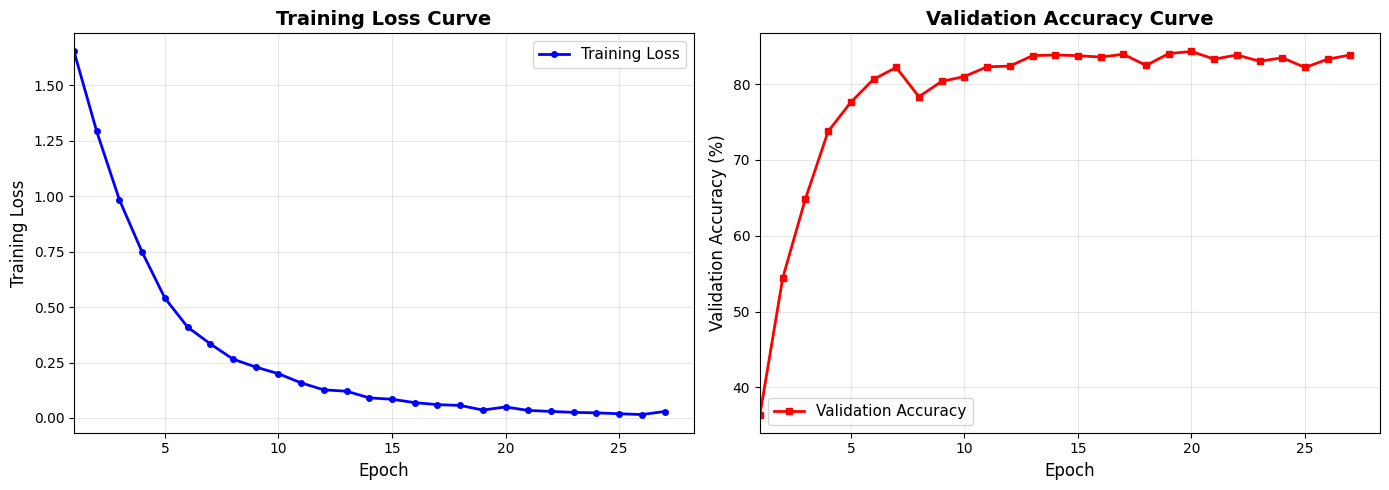


REGULARIZATION TUNING COMPLETE


In [34]:
# ============================================================================
# Regularization Final: All Best Combined
# ============================================================================
print("\n" + "="*80)
print("REGULARIZATION FINAL: ALL BEST SETTINGS COMBINED")
print("="*80)
print(f"Best settings from all steps:")
print(f"    Gradient Clipping: {best_grad_clip}")
print(f"    Dropout: {best_dropout}")
print(f"    L1 Lambda: {best_l1_lambda}")
print(f"    L2 Lambda: {best_l2_lambda}")

# Create model with all best settings
model = RNN_Classifier_Aggregation(
    vocab_size=fasttext_vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=best_hidden_dim,
    output_dim=num_classes,
    n_layers=N_LAYERS,
    dropout=best_dropout,
    padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
    pretrained_embeddings=pretrained_embeddings,
    aggregation=best_aggregation['method']
).to(device)

# Select optimizer with best L2 (weight_decay)
if best_optimizer == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)
elif best_optimizer == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=final_lr, momentum=0.9, weight_decay=best_l2_lambda)
elif best_optimizer == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)
elif best_optimizer == 'Adagrad':
    optimizer = optim.Adagrad(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)

# Training loop
best_val_acc = 0.0
patience_counter = 0

# Store training history for plotting
train_losses = []
val_accs = []

print(f"\n>>> Training final model with all best regularization settings...")

for epoch in range(MAX_EPOCHS):
    model.train()
    train_loss = 0
    train_preds = []
    train_labels = []
    num_batches = 0
    
    for batch in train_iter:
        num_batches += 1
        text, text_lengths, labels = process_batch(batch, debug=False)
        optimizer.zero_grad()
        predictions = model(text, text_lengths)
        
        loss = criterion(predictions, labels)
        
        if best_l1_lambda > 0:
            loss = loss + compute_l1_loss(model, best_l1_lambda)
        
        loss.backward()
        
        if best_grad_clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), best_grad_clip)
        
        optimizer.step()
        
        train_loss += loss.item()
        preds = torch.argmax(predictions, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())
    
    train_acc = accuracy_score(train_labels, train_preds)
    # Calculate average training loss (train_loss is sum over all batches)
    num_train_batches = len(train_labels) // train_iter.batch_size + (1 if len(train_labels) % train_iter.batch_size != 0 else 0)
    train_loss_avg = train_loss / num_train_batches if num_train_batches > 0 else train_loss
    
    model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []
    
    with torch.no_grad():
        for batch in val_iter:
            text, text_lengths, labels = process_batch(batch, debug=False)
            predictions = model(text, text_lengths)
            loss = criterion(predictions, labels)
            val_loss += loss.item()
            
            preds = torch.argmax(predictions, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    val_acc = accuracy_score(val_labels, val_preds)
    
    # Store training history for plotting
    train_losses.append(train_loss_avg)
    val_accs.append(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'rnn_reg_final_best.pt')
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"    Early stopping at epoch {epoch+1}, best val acc: {best_val_acc*100:.2f}%")
            break
    
    if (epoch + 1) % 10 == 0:
        print(f"    Epoch {epoch+1}: Train Acc={train_acc*100:.2f}%, Val Acc={val_acc*100:.2f}%")

# Evaluate on test set
model.load_state_dict(torch.load('rnn_reg_final_best.pt'))
model.eval()

test_loss = 0
test_preds = []
test_labels = []
test_probs = []

with torch.no_grad():
    for batch in test_iter:
        text, text_lengths, labels = process_batch(batch, debug=False)
        predictions = model(text, text_lengths)
        loss = criterion(predictions, labels)
        test_loss += loss.item()
        
        probs = torch.softmax(predictions, dim=1)
        preds = torch.argmax(predictions, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())

test_acc = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds, average='weighted')
test_loss_avg = test_loss / len(test_iter)

try:
    test_probs_array = np.array(test_probs)
    test_labels_bin = label_binarize(test_labels, classes=range(num_classes))
    test_auc = roc_auc_score(test_labels_bin, test_probs_array, average='weighted', multi_class='ovr')
except Exception as e:
    print(f"Warning: Could not calculate AUC-ROC: {e}")
    test_auc = 0.0

final_results = {
    'name': 'final_combined',
    'dropout': best_dropout,
    'grad_clip': best_grad_clip,
    'l1_lambda': best_l1_lambda,
    'l2_lambda': best_l2_lambda,
    'val_acc': best_val_acc,
    'test_acc': test_acc,
    'test_f1': test_f1,
    'test_auc': test_auc
}

print(f"\n>>> Final Combined Results:")
print(f"    Configuration:")
print(f"      - Gradient Clipping: {best_grad_clip}")
print(f"      - Dropout: {best_dropout}")
print(f"      - L1 Lambda: {best_l1_lambda}")
print(f"      - L2 Lambda: {best_l2_lambda}")
print(f"    Validation Acc: {best_val_acc*100:.2f}%")
print(f"    Test Acc: {test_acc*100:.2f}%")
print(f"    Test F1: {test_f1:.4f}")
print(f"    Test AUC-ROC: {test_auc:.4f}")

# Compare with baseline
improvement = test_acc - baseline_results['test_acc']
improvement_pct = (improvement / baseline_results['test_acc']) * 100 if baseline_results['test_acc'] > 0 else 0

print(f"\n>>> Comparison with Baseline:")
print(f"    Baseline Test Acc: {baseline_results['test_acc']*100:.2f}%")
print(f"    Final Regularized Test Acc: {test_acc*100:.2f}%")
print(f"    Improvement: {improvement*100:+.2f}% ({improvement_pct:+.2f}% relative)")

# Plot training curves for best configuration and regularization
print(f"\n>>> Plotting training curves for best configuration and regularization...")
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training Loss vs Epochs
epochs = range(1, len(train_losses) + 1)
ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2, marker='o', markersize=4)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Loss', fontsize=12)
ax1.set_title('Training Loss Curve', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(left=1)

# Plot 2: Validation Accuracy vs Epochs
ax2.plot(epochs, [acc*100 for acc in val_accs], 'r-', label='Validation Accuracy', linewidth=2, marker='s', markersize=4)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Accuracy (%)', fontsize=12)
ax2.set_title('Validation Accuracy Curve', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(left=1)

plt.tight_layout()
plt.savefig('best_config_training_curves.png', dpi=300, bbox_inches='tight')
print(f"    Saved training curves to 'best_config_training_curves.png'")
plt.show()

print(f"\n{'='*80}")
print("REGULARIZATION TUNING COMPLETE")
print(f"{'='*80}")


In [ ]:
# seed = 42
# np.random.seed(seed)
# torch.manual_seed(seed)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed(seed)

# # Build vocabulary for labels
# LABEL.build_vocab(train_data)
# num_classes = len(LABEL.vocab)
# print(f"\nNumber of classes: {num_classes}")
# print(f"Classes: {LABEL.vocab.itos}")

# # Create iterators for batching
# def create_iterators(train_data, validation_data, test_data, batch_size):
#     train_iterator = data.BucketIterator(
#         train_data,
#         batch_size=batch_size,
#         sort_key=lambda x: len(x.text),
#         sort_within_batch=True,
#         device=device
#     )
    
#     val_iterator = data.BucketIterator(
#         validation_data,
#         batch_size=batch_size,
#         sort_key=lambda x: len(x.text),
#         sort_within_batch=True,
#         device=device
#     )
    
#     test_iterator = data.BucketIterator(
#         test_data,
#         batch_size=batch_size,
#         sort_key=lambda x: len(x.text),
#         sort_within_batch=True,
#         device=device
#     )
    
#     return train_iterator, val_iterator, test_iterator


# class RNN_Classifier(nn.Module):
#     """
#     Simple RNN for topic classification with multiple aggregation strategies
#     """
#     def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
#                  n_layers=1, bidirectional=False, dropout=0.5, 
#                  padding_idx=0, pretrained_embeddings=None,
#                  aggregation='last'):
#         super(RNN_Classifier, self).__init__()
        
#         self.hidden_dim = hidden_dim
#         self.n_layers = n_layers
#         self.bidirectional = bidirectional
#         self.aggregation = aggregation  # 'last', 'mean', 'max', 'attention'
        
#         # Embedding layer
#         self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        
#         # Initialize with pretrained embeddings
#         if pretrained_embeddings is not None:
#             self.embedding.weight.data.copy_(pretrained_embeddings)
        
#         # Make embeddings learnable (updated during training)
#         self.embedding.weight.requires_grad = True
        
#         # RNN layer
#         self.rnn = nn.RNN(
#             embedding_dim,
#             hidden_dim,
#             num_layers=n_layers,
#             bidirectional=bidirectional,
#             batch_first=True,
#             dropout=dropout if n_layers > 1 else 0
#         )
        
#         # Dropout layer
#         self.dropout = nn.Dropout(dropout)
        
#         # Attention mechanism for aggregation
#         if aggregation == 'attention':
#             rnn_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
#             self.attention = nn.Linear(rnn_output_dim, 1)
        
#         # Fully connected output layer
#         rnn_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
#         self.fc = nn.Linear(rnn_output_dim, output_dim)
        
#     def forward(self, text, text_lengths):
#         # text: [batch_size, seq_len]
#         # text_lengths: [batch_size]
        
#         # Embed the input
#         embedded = self.dropout(self.embedding(text))
#         # embedded: [batch_size, seq_len, embedding_dim]
        
#         # Pack the padded sequences
#         packed_embedded = nn.utils.rnn.pack_padded_sequence(
#             embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False
#         )
        
#         # Pass through RNN
#         packed_output, hidden = self.rnn(packed_embedded)
#         # packed_output: packed sequence of [batch_size, seq_len, hidden_dim * num_directions]
#         # hidden: [n_layers * num_directions, batch_size, hidden_dim]
        
#         # Unpack the sequences
#         output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
#         # output: [batch_size, seq_len, hidden_dim * num_directions]
        
#         # Aggregate word representations to sentence representation
#         if self.aggregation == 'last':
#             # Use the last hidden state
#             if self.bidirectional:
#                 # Concatenate last states from forward and backward
#                 hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
#             else:
#                 hidden = hidden[-1,:,:]
#             sentence_repr = hidden
            
#         elif self.aggregation == 'mean':
#             # Mean pooling over all outputs (ignoring padding)
#             # Create mask for padding
#             batch_size, seq_len, hidden_size = output.size()
#             mask = torch.arange(seq_len, device=device).unsqueeze(0) < text_lengths.unsqueeze(1)
#             mask = mask.unsqueeze(2).float()  # [batch_size, seq_len, 1]
            
#             # Apply mask and compute mean
#             masked_output = output * mask
#             sum_output = masked_output.sum(dim=1)
#             sentence_repr = sum_output / text_lengths.unsqueeze(1).float()
            
#         elif self.aggregation == 'max':
#             # Max pooling over all outputs
#             sentence_repr, _ = torch.max(output, dim=1)
            
#         elif self.aggregation == 'attention':
#             # Attention mechanism
#             # Compute attention scores
#             attn_scores = self.attention(output).squeeze(2)  # [batch_size, seq_len]
            
#             # Mask padding positions
#             mask = torch.arange(output.size(1), device=device).unsqueeze(0) < text_lengths.unsqueeze(1)
#             attn_scores = attn_scores.masked_fill(~mask, float('-inf'))
            
#             # Apply softmax
#             attn_weights = torch.softmax(attn_scores, dim=1).unsqueeze(1)  # [batch_size, 1, seq_len]
            
#             # Weighted sum
#             sentence_repr = torch.bmm(attn_weights, output).squeeze(1)  # [batch_size, hidden_dim * num_directions]
        
#         # Apply dropout
#         sentence_repr = self.dropout(sentence_repr)
        
#         # Pass through fully connected layer
#         output = self.fc(sentence_repr)
        
#         return output


# def count_parameters(model):
#     """Count trainable parameters"""
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)


# def train_epoch(model, iterator, optimizer, criterion, device, l1_lambda=0.0, l2_lambda=0.0):
#     """Train for one epoch"""
#     model.train()
#     epoch_loss = 0
#     all_preds = []
#     all_labels = []
    
#     for batch in iterator:
#         text, text_lengths = batch.text
#         labels = batch.label
        
#         # Zero gradients
#         optimizer.zero_grad()
        
#         # Forward pass
#         predictions = model(text, text_lengths)
        
#         # Calculate loss
#         loss = criterion(predictions, labels)
        
#         # Add L1 regularization
#         if l1_lambda > 0:
#             l1_norm = sum(p.abs().sum() for p in model.parameters())
#             loss = loss + l1_lambda * l1_norm
        
#         # Add L2 regularization (can also use weight_decay in optimizer)
#         if l2_lambda > 0:
#             l2_norm = sum(p.pow(2).sum() for p in model.parameters())
#             loss = loss + l2_lambda * l2_norm
        
#         # Backward pass
#         loss.backward()
        
#         # Gradient clipping to prevent exploding gradients
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
#         # Update weights
#         optimizer.step()
        
#         epoch_loss += loss.item()
        
#         # Store predictions and labels for metrics
#         preds = torch.argmax(predictions, dim=1)
#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())
    
#     # Calculate metrics
#     accuracy = accuracy_score(all_labels, all_preds)
#     f1 = f1_score(all_labels, all_preds, average='weighted')
    
#     return epoch_loss / len(iterator), accuracy, f1


# def evaluate(model, iterator, criterion, device, return_predictions=False):
#     """Evaluate the model"""
#     model.eval()
#     epoch_loss = 0
#     all_preds = []
#     all_labels = []
#     all_probs = []
    
#     with torch.no_grad():
#         for batch in iterator:
#             text, text_lengths = batch.text
#             labels = batch.label
            
#             # Forward pass
#             predictions = model(text, text_lengths)
            
#             # Calculate loss
#             loss = criterion(predictions, labels)
#             epoch_loss += loss.item()
            
#             # Store predictions and labels
#             probs = torch.softmax(predictions, dim=1)
#             preds = torch.argmax(predictions, dim=1)
            
#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())
#             all_probs.extend(probs.cpu().numpy())
    
#     # Calculate metrics
#     accuracy = accuracy_score(all_labels, all_preds)
#     f1 = f1_score(all_labels, all_preds, average='weighted')
    
#     # Calculate AUC-ROC (one-vs-rest for multiclass)
#     try:
#         all_probs_array = np.array(all_probs)
#         all_labels_bin = label_binarize(all_labels, classes=range(num_classes))
#         auc_roc = roc_auc_score(all_labels_bin, all_probs_array, average='weighted', multi_class='ovr')
#     except:
#         auc_roc = 0.0
    
#     if return_predictions:
#         return epoch_loss / len(iterator), accuracy, f1, auc_roc, all_preds, all_labels
    
#     return epoch_loss / len(iterator), accuracy, f1, auc_roc


# def train_model(model, train_iterator, val_iterator, optimizer, criterion, 
#                 n_epochs, device, patience=5, l1_lambda=0.0, l2_lambda=0.0,
#                 save_path='best_model.pt'):
#     """
#     Train the model with early stopping
#     """
#     best_val_acc = 0
#     patience_counter = 0
    
#     train_losses = []
#     train_accs = []
#     val_losses = []
#     val_accs = []
    
#     print(f"\nStarting training for {n_epochs} epochs...")
#     print(f"Device: {device}")
#     print(f"Model parameters: {count_parameters(model):,}")
    
#     for epoch in range(n_epochs):
#         start_time = time.time()
        
#         # Train
#         train_loss, train_acc, train_f1 = train_epoch(
#             model, train_iterator, optimizer, criterion, device, l1_lambda, l2_lambda
#         )
        
#         # Evaluate on validation set
#         val_loss, val_acc, val_f1, val_auc = evaluate(model, val_iterator, criterion, device)
        
#         end_time = time.time()
#         epoch_mins, epoch_secs = divmod(end_time - start_time, 60)
        
#         # Store metrics
#         train_losses.append(train_loss)
#         train_accs.append(train_acc)
#         val_losses.append(val_loss)
#         val_accs.append(val_acc)
        
#         print(f'Epoch: {epoch+1:02}/{n_epochs} | Time: {int(epoch_mins)}m {int(epoch_secs)}s')
#         print(f'\tTrain Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Train F1: {train_f1:.4f}')
#         print(f'\tVal Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}% | Val F1: {val_f1:.4f} | Val AUC: {val_auc:.4f}')
        
#         # Early stopping
#         if val_acc > best_val_acc:
#             best_val_acc = val_acc
#             patience_counter = 0
#             # Save best model
#             torch.save(model.state_dict(), save_path)
#             print(f'\t>>> New best model saved with Val Acc: {val_acc*100:.2f}%')
#         else:
#             patience_counter += 1
#             print(f'\t>>> No improvement. Patience: {patience_counter}/{patience}')
            
#             if patience_counter >= patience:
#                 print(f'\nEarly stopping triggered after epoch {epoch+1}')
#                 break
    
#     return {
#         'train_losses': train_losses,
#         'train_accs': train_accs,
#         'val_losses': val_losses,
#         'val_accs': val_accs,
#         'best_val_acc': best_val_acc
#     }


# def evaluate_per_topic(model, iterator, device):
#     """Evaluate model performance per topic category"""
#     model.eval()
    
#     topic_correct = defaultdict(int)
#     topic_total = defaultdict(int)
    
#     with torch.no_grad():
#         for batch in iterator:
#             text, text_lengths = batch.text
#             labels = batch.label
            
#             # Forward pass
#             predictions = model(text, text_lengths)
#             preds = torch.argmax(predictions, dim=1)
            
#             # Count per topic
#             for pred, label in zip(preds.cpu().numpy(), labels.cpu().numpy()):
#                 topic_name = LABEL.vocab.itos[label]
#                 topic_total[topic_name] += 1
#                 if pred == label:
#                     topic_correct[topic_name] += 1
    
#     # Calculate accuracy per topic
#     topic_accuracies = {}
#     for topic in sorted(topic_total.keys()):
#         acc = topic_correct[topic] / topic_total[topic] if topic_total[topic] > 0 else 0
#         topic_accuracies[topic] = acc
#         print(f'{topic}: {topic_correct[topic]}/{topic_total[topic]} = {acc*100:.2f}%')
    
#     return topic_accuracies


# def plot_training_curves(history, save_prefix='rnn'):
#     """Plot training and validation curves"""
#     fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
#     # Loss curve
#     axes[0].plot(history['train_losses'], label='Train Loss', marker='o')
#     axes[0].plot(history['val_losses'], label='Val Loss', marker='s')
#     axes[0].set_xlabel('Epoch')
#     axes[0].set_ylabel('Loss')
#     axes[0].set_title('Training and Validation Loss')
#     axes[0].legend()
#     axes[0].grid(True, alpha=0.3)
    
#     # Accuracy curve
#     axes[1].plot([acc*100 for acc in history['train_accs']], label='Train Acc', marker='o')
#     axes[1].plot([acc*100 for acc in history['val_accs']], label='Val Acc', marker='s')
#     axes[1].set_xlabel('Epoch')
#     axes[1].set_ylabel('Accuracy (%)')
#     axes[1].set_title('Training and Validation Accuracy')
#     axes[1].legend()
#     axes[1].grid(True, alpha=0.3)
    
#     plt.tight_layout()
#     plt.savefig(f'{save_prefix}_training_curves.png', dpi=200)
#     plt.close()
#     print(f'Saved training curves to {save_prefix}_training_curves.png')

In [ ]:
# print("\n" + "="*80)
# print("PART 2: RNN MODEL TRAINING")
# print("="*80)

# # Get pretrained embeddings from Part 1
# pretrained_embeddings = fatter_embedding.weight.data.clone()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Hyperparameters for baseline
# BATCH_SIZE = 64
# HIDDEN_DIM = 256
# N_LAYERS = 1
# DROPOUT = 0.5
# N_EPOCHS = 50
# LEARNING_RATE = 0.001
# PATIENCE = 10

# # Create data iterators
# train_iterator, val_iterator, test_iterator = create_iterators(
#     train_data, validation_data, test_data, BATCH_SIZE
# )

# # Initialize baseline model
# baseline_model = RNN_Classifier(
#     vocab_size=len(TEXT.vocab),
#     embedding_dim=embedding_dim,
#     hidden_dim=HIDDEN_DIM,
#     output_dim=num_classes,
#     n_layers=N_LAYERS,
#     bidirectional=False,
#     dropout=DROPOUT,
#     padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
#     pretrained_embeddings=pretrained_embeddings,
#     aggregation='last'
# ).to(device)

# # Loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(baseline_model.parameters(), lr=LEARNING_RATE)

# print(f"\n>>> Training Baseline RNN Model")
# print(f"Configuration: Hidden={HIDDEN_DIM}, Layers={N_LAYERS}, Dropout={DROPOUT}, LR={LEARNING_RATE}, Batch={BATCH_SIZE}")

# # Train baseline model
# baseline_history = train_model(
#     baseline_model, train_iterator, val_iterator, optimizer, criterion,
#     n_epochs=N_EPOCHS, device=device, patience=PATIENCE,
#     save_path='rnn_baseline_best.pt'
# )

# # Load best model and evaluate on test set
# baseline_model.load_state_dict(torch.load('rnn_baseline_best.pt'))
# test_loss, test_acc, test_f1, test_auc = evaluate(baseline_model, test_iterator, criterion, device)

# print(f"\n>>> Baseline Model Test Results:")
# print(f"Test Loss: {test_loss:.4f}")
# print(f"Test Accuracy: {test_acc*100:.2f}%")
# print(f"Test F1 Score: {test_f1:.4f}")
# print(f"Test AUC-ROC: {test_auc:.4f}")

# # Topic-wise accuracy
# print(f"\n>>> Topic-wise Accuracy (Baseline):")
# baseline_topic_acc = evaluate_per_topic(baseline_model, test_iterator, device)

# # Plot training curves
# plot_training_curves(baseline_history, save_prefix='rnn_baseline')